# IMPORTS

In [1]:
import os
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from collections import defaultdict
from scipy.stats import beta
from scipy.special import betaln
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from accelerate import Accelerator, notebook_launcher
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
data_used = manager.list()
sampling_dur = manager.list()
new_samples = manager.list()

# Non shared resources
filename = 'dat-besra'
epochs = 10
batch_size = 4
sequence_length = 192

# LOAD AND PREPROCESS DATA

In [6]:
data = pd.read_csv('/kaggle/input/doctors-answer-text-dataset/Indo-Online Health Consultation-Medical Interview-Clean.csv', encoding='latin-1')
data.head()

,No,answer,1-FR,2-GI,3-PI,4-DM,5-EDTRB,6-RE,Text_Clean,filtered_text,token,tokens_stemmed,Process_Data
0,1,"Halo Rizal,Radang tenggorokan umunya disebabka...",1,0,1,1,1,0,halo rizal radang tenggorokan umunya disebabka...,halo rizal radang tenggorokan umunya disebabka...,"['halo', 'rizal', 'radang', 'tenggorokan', 'um...","['halo', 'rizal', 'radang', 'tenggorok', 'umu'...",halo rizal radang tenggorok umu sebab infeksi ...
1,2,"Halo Hellas,Cacar air merupakan suatu penyakit...",1,0,1,1,1,0,halo hellas cacar air merupakan suatu penyakit...,halo hellas cacar air penyakit disebabkan viru...,"['halo', 'hellas', 'cacar', 'air', 'penyakit',...","['halo', 'hellas', 'cacar', 'air', 'sakit', 's...",halo hellas cacar air sakit sebab virus varise...
2,3,Halo Rory.......Terimakasih atas pertanyaan An...,1,0,1,1,1,0,halo rory terimakasih atas pertanyaan anda per...,halo rory terimakasih ketahui gangguan kulit s...,"['halo', 'rory', 'terimakasih', 'ketahui', 'ga...","['halo', 'rory', 'terimakasih', 'tahu', 'gangg...",halo rory terimakasih tahu ganggu kulit rangka...
3,4,"Alo AfriYani, Terimakasih atas pertanyaannya. ...",1,0,1,1,1,0,alo afriyani terimakasih atas pertanyaannya ku...,alo afriyani terimakasih pertanyaannya kuku ja...,"['alo', 'afriyani', 'terimakasih', 'pertanyaan...","['alo', 'afriyani', 'terimakasih', 'tanya', 'k...",alo afriyani terimakasih tanya kuku jari kaki ...
4,5,"Halo,Telinga berdenging atau tinitus merupak...",1,0,1,1,1,0,halo telinga berdenging atau tinitus merupakan...,halo telinga berdenging tinitus sensasi penden...,"['halo', 'telinga', 'berdenging', 'tinitus', '...","['halo', 'telinga', 'denging', 'tinitus', 'sen...",halo telinga denging tinitus sensasi dengar de...


In [7]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

train_labels = train_data.columns[2:8]
val_labels = val_data.columns[2:8]
# Extract features and labels for training and validation
X_train = train_data['Text_Clean'].values
y_train = train_data[train_labels].values
X_val = val_data['Text_Clean'].values
y_val = val_data[val_labels].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(400,) (400, 6)
(100,) (100, 6)


# BUILD DATASET & DATALOADERS

In [8]:
class DoctorAnswerDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float)
        return item

    def get_per_class_probs(self):
        """
        Calculate the spread of labels (0 and 1) for each class in the dataset.
        Returns:
            dict: A dictionary where keys are class indices and values are [count_0, count_1].
        """

        # Initialize a dictionary to store counts for each class
        label_counts = defaultdict(lambda: [0, 0])  # [count_0, count_1] for each class

        for i in range(len(self)):
            # Get the labels for the i-th sample
            labels = self[i]['labels']

            # Update counts for each class
            for class_idx, label in enumerate(labels):
                label_counts[class_idx][int(label)] += 1

        for key in label_counts.keys():
            total = sum(label_counts[key])
            label_counts[key] = [x / total for x in label_counts[key]]

        return label_counts

    def get_global_probs(self):
        """
        Calculate the global count of 0s and 1s across all classes in the dataset.
        Returns:
            dict: A dictionary with keys '0' and '1' representing their global counts.
        """
        global_counts = {'0': 0, '1': 0}

        for i in range(len(self)):
            # Get the labels for the i-th sample
            labels = self[i]['labels']

            # Update global counts
            for label in labels:
                global_counts[str(int(label))] += 1

        total = global_counts['0'] + global_counts['1']
        for key in global_counts.keys():
            global_counts[key] /= total

        return global_counts


# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p2')

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [9]:
def get_dataloaders(X_train, y_train, X_val, y_val, sequence_length=256, num_workers=4):
    train_dataset = DoctorAnswerDataset(X_train, y_train, tokenizer, max_length=sequence_length)
    val_dataset = DoctorAnswerDataset(X_val, y_val, tokenizer, max_length=sequence_length)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers
    )

    return train_loader, val_loader

In [10]:
get_dataloaders(X_train, y_train, X_val, y_val)

(<torch.utils.data.dataloader.DataLoader at 0x7d8cd9fb0c70>,
 <torch.utils.data.dataloader.DataLoader at 0x7d8cd9fb1810>)

# TRAIN THE MODEL

In [11]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 10

In [12]:
def compute_metrics(p):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        target_names=['1-FR', '2-GI', '3-PI', '4-DM', '5-EDTRB', '6-RE'],
        zero_division=0
    )  

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [13]:
def train_model(current_train_size, train_indices, metrics, trials, i):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    train_loader, val_loader = get_dataloaders(current_X_train, current_y_train, X_val, y_val)

    with accelerator.main_process_first():
        model = BertForSequenceClassification.from_pretrained(
            'indobenchmark/indobert-base-p2',
            num_labels=len(train_labels),
            problem_type="multi_label_classification"
        )
        
    # Define optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Prepare everything with Accelerator
    model, optimizer, train_loader, val_loader = accelerator.prepare(
        model, optimizer, train_loader, val_loader
    )

    best_result = None
    start_time = time.time()
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key != 'labels'}
            labels = batch['labels']

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            optimizer.step()

            epoch_loss += loss.item()

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                inputs = {key: val for key, val in batch.items() if key != 'labels'}
                labels = batch['labels']
                
                outputs = model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}))

        if best_result is None or result['f1_micro'] >= best_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(
                f'{filename}-{trials+1}-model-{i+1}',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            best_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    accelerator.print(f"Model {i+1} - Iteration {current_train_size}: Accuracy: {round(best_result['accuracy'], 4)}, F1 Micro: {round(best_result['f1_micro'], 4)}, F1 Macro: {round(best_result['f1_macro'], 4)}")
    accelerator.print(best_result['report'])
        
    end_time = time.time()
    duration = end_time - start_time
    
    accelerator.print(f"Training completed in {duration} s")
    
    # Update the shared lists
    if accelerator.is_local_main_process:
        metrics[0].append(best_result['accuracy'])
        metrics[1].append(best_result['f1_micro'])
        metrics[2].append(best_result['f1_macro'])

# PLOT RESULT

In [14]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [15]:
def beta_score(p, y, alpha=0.1, beta=3):
    """Calculates Beta score for a given probability p and label y."""
    
    if y == 1:
        return -betaln(alpha, beta + 1) + betaln(alpha + p, beta + 1 - p)
    elif y == 0:
        return -betaln(alpha + 1, beta) + betaln(alpha + 1 - p, beta + p)
    else:
        raise ValueError("Invalid label: y must be 0 or 1.")

def bayesian_update(prior, likelihood, evidence, alpha=0.1, beta_param=3):
    """ 
    Bayes' Theorem: P(y'|x') = P(x'|y') * P(y') / P(x')
    P(y'|x') or likelihood = model probs
    p(y') or prior = class probabilities
    p(x') or evidence = 1 / number of data
    """
    
    # Using the Beta score to simulate the posterior
    posterior = (likelihood * prior) / evidence
    
    # We calculate the posterior using the Beta distribution
    return posterior

def compute_expected_score_change(predicted_prob, class_probs, label_probs, class_idx):
    scores_before = []
    scores_after = []

    # Before data addition: calculate Beta score for predicted prob
    scores_before.append(beta_score(predicted_prob, int(1 if predicted_prob >= 0.5 else 0)))
    scores_before.append(beta_score(1-predicted_prob, int(1 if predicted_prob >= 0.5 else 0)))
    
    # After data addition: use Bayesian update (posterior probability)
    for k in range(2):
        prior = predicted_prob
        likelihood = class_probs[class_idx][k]  # Likelihood is the true label (0 or 1)
        posterior = bayesian_update(prior, likelihood, 1)
        scores_after.append(beta_score(posterior, int(1 if posterior >= 0.5 else 0)))

    score_diff_0 = scores_after[0] - scores_before[0]
    score_diff_1 = scores_after[1] - scores_before[1]
    return label_probs['0'] * score_diff_0 + label_probs['1'] * score_diff_1

# Function to compute Expected Score Change (∆Q)
def besra_sampling(models, X_pool, train_indices, remaining_indices, tokenizer, sampling_dur, new_samples, trials, n_clusters=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device
    
    dataset = DoctorAnswerDataset(X_pool, np.zeros((len(X_pool), 6)), tokenizer, max_length=sequence_length)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
    )

    current_train_size = len(train_indices)
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    labeled_dataset = DoctorAnswerDataset(current_X_train, current_y_train, tokenizer, max_length=sequence_length)
    label_probs = labeled_dataset.get_global_probs()
    class_probs = labeled_dataset.get_per_class_probs()

    for model in models:
        model.to(device)
        model.eval()
    start_time = time.time()
    score_changes = []

    for batch in dataloader:
        input_ids = batch['input_ids'].to(model.device)
        attention_mask = batch['attention_mask'].to(model.device)
        labels = batch['labels'].to(model.device)

        model_probs = []

        for model in models:
            with torch.no_grad():
                outputs = model(input_ids, attention_mask=attention_mask)
                logits = outputs.logits
                probs = torch.sigmoid(logits)  # Multi-label classification uses sigmoid
                model_probs.append(probs.unsqueeze(0))  # Add batch dimension for averaging
        
        # Stack all model predictions and compute the mean across models
        model_probs = torch.cat(model_probs, dim=0)  # Concatenate predictions across models
        probs = model_probs.mean(dim=0)  # Take the mean along the model axis

        # Calculate Beta scores before and after data addition
        for i in range(len(probs)):
            score_diff = []
            for class_idx in range(probs.shape[1]):
                predicted_prob = probs[i, class_idx].item()
                score_diff.append(compute_expected_score_change(predicted_prob, class_probs, label_probs, class_idx))
            
            score_changes.append(np.mean(score_diff))
    
    accelerator.wait_for_everyone()    
    if accelerator.is_local_main_process:
        score_changes = np.array(score_changes)
        score_changes = score_changes.reshape(-1, 1)

        target_samples = math.ceil(0.1 * len(X_pool))
        collected_indices = set()
        thresholds = []
    
        # Check nearest checkpoint
        nearest_cp = 0
        arrived_at_cp = False
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break

        # Determine number of maximum samples to be acquired
        if target_samples <= n_clusters and n_clusters < nearest_cp - current_train_size:
            target_samples = n_clusters
        elif target_samples > n_clusters and target_samples < nearest_cp - current_train_size:
            target_samples = target_samples
        else:
            arrived_at_cp = True
            target_samples = nearest_cp - current_train_size

        # No clustering needed when there's little data left
        if current_train_size >= checkpoints[len(checkpoints)-1] - min_increment:
            end_time = time.time()
            duration = end_time - start_time
            
            temp = train_indices.copy()
            temp.extend(remaining_indices)
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                '1-FR': [y_train[i][0] for i in temp],
                '2-GI': [y_train[i][1] for i in temp],
                '3-PI': [y_train[i][2] for i in temp],
                '4-DM': [y_train[i][3] for i in temp],
                '5-EDTRB': [y_train[i][4] for i in temp],
                '6-RE': [y_train[i][5] for i in temp],
            })
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)

            print("Nearest checkpoint:", nearest_cp)
            print("Acquired samples:", len(remaining_indices))
            print(f"Sampling duration: {duration} seconds")
            
            sampling_dur.append(duration)
            for i in remaining_indices:
                new_samples.append(i)

        else:
            # Cluster the data based on its embeddings
            kmeans=KMeans(n_clusters=n_clusters, n_init=1)
            kmeans.fit(score_changes)
            
            for cluster_id in range(n_clusters):
                # Cluster center and indices of samples in the current cluster
                cluster_center = kmeans.cluster_centers_[cluster_id]
                cluster_indices = np.where(kmeans.labels_ == cluster_id)[0]
            
                if cluster_indices.size == 0:
                    # Skip clusters with no members
                    print(f"Cluster {cluster_id} has no members, skipping.")
                    continue
            
                # Calculate distances of each point in the cluster from the cluster center
                cluster_distances = np.linalg.norm(score_changes[cluster_indices] - cluster_center, axis=1)
            
                # Determine the local threshold (10th percentile of closest distances to cluster center)
                local_threshold = np.percentile(cluster_distances, 90)
                thresholds.append(local_threshold)
            
                below_threshold_indices = cluster_indices[cluster_distances >= local_threshold]
                collected_indices.update(below_threshold_indices)

            # To handle multiple points with same distance
            if len(collected_indices) > target_samples:
                collected_indices = np.array(list(collected_indices))
                np.random.shuffle(collected_indices)
                collected_indices = collected_indices[:target_samples]
                
            end_time = time.time() 
            duration = end_time - start_time 
    
            if arrived_at_cp:
                temp = train_indices.copy()
                temp.extend(collected_indices)
                
                # Save acquired data up to checkpoint
                acquired_data = pd.DataFrame({
                    'processed_text': [X_train[i] for i in temp],
                    '1-FR': [y_train[i][0] for i in temp],
                    '2-GI': [y_train[i][1] for i in temp],
                    '3-PI': [y_train[i][2] for i in temp],
                    '4-DM': [y_train[i][3] for i in temp],
                    '5-EDTRB': [y_train[i][4] for i in temp],
                    '6-RE': [y_train[i][5] for i in temp],
                })
        
                acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
            
            print("Nearest checkpoint:", nearest_cp)
            print("Acquired samples:", len(collected_indices))
            print(f"Sampling duration: {duration} seconds")
        
            sampling_dur.append(duration)
            for i in collected_indices:
                new_samples.append(remaining_indices[i])

        threshold_data = pd.DataFrame({
            'Threshold': thresholds
        })
        threshold_data.to_csv(f"results/{filename}-thresholds-{trials+1}-{current_train_size}.csv", index=False)

# MAIN LOOP

In [16]:
def active_learning(seed, i):
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()
    
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size

    
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        model_accuracies = manager.list()
        model_f1_micros = manager.list()
        model_f1_macros = manager.list()
        
        # Train the model
        for j in range(3):
            set_seed(seed[j])
            args = (current_train_size, train_indices, (model_accuracies, model_f1_micros, model_f1_macros), i, j)
            notebook_launcher(train_model, args, num_processes=2)

        data_used.append(current_train_size)
        accuracies.append(np.mean(model_accuracies))
        f1_micros.append(np.mean(model_f1_micros))
        f1_macros.append(np.mean(model_f1_macros))
        print(f"Averaged - Iteration {current_train_size}: Accuracy: {round(np.mean(accuracies), 4)}, F1 Micro: {round(np.mean(f1_micros), 4)}, F1 Macro: {round(np.mean(f1_macros), 4)}")

        models = []
        for j in range(3):
            model = BertForSequenceClassification.from_pretrained(f'{filename}-{i+1}-model-{j+1}')
            models.append(model)
        
        # Perform query strategy to select new samples
        new_samples = manager.list()
        sampling_args = (models, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, tokenizer, sampling_dur, new_samples, i)
        notebook_launcher(besra_sampling, sampling_args, num_processes=2)
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    model_accuracies = manager.list()
    model_f1_micros = manager.list()
    model_f1_macros = manager.list()
    
    for j in range(3):
        set_seed(seed[j])
        args = (current_train_size, train_indices, (model_accuracies, model_f1_micros, model_f1_macros), i, j)
        notebook_launcher(train_model, args, num_processes=2)
        
    data_used.append(current_train_size)
    accuracies.append(np.mean(model_accuracies))
    f1_micros.append(np.mean(model_f1_micros))
    f1_macros.append(np.mean(model_f1_macros))
    print(f"Averaged - Iteration {current_train_size}: Accuracy: {round(np.mean(accuracies), 4)}, F1 Micro: {round(np.mean(f1_micros), 4)}, F1 Macro: {round(np.mean(f1_macros), 4)}")
        
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    
    end_time = time.time()
    duration = end_time - start_time
    
    print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)

In [17]:
seeds = [[50, 67, 42], [81, 90, 11], [14, 7, 33], [3, 44, 85], [94, 21, 5]]

## RUN 1

TRIAL 1
Random seed: [50, 67, 42]
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5938, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3975, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2793, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2126, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2185, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1651, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2095, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1328, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.638, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4006, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.296, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2339, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2347, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1755, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2175, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1383, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5657, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3775, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2687, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2018, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2273, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.156, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2098, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1346, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4884, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.232, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1879, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1546, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1461, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1418, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1161, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0974, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5064, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2491, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1913, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1625, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1524, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1454, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1278, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0997, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4589, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2181, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1785, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1519, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1482, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1414, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1217, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0971, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3826, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1972, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1823, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1361, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.136, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1057, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1103, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6536
Epoch 8/10, Train Loss: 0.1167, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.6528
Epoch 9/10, Train Loss: 0.084, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4229, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2101, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1872, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1429, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1382, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1081, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1222, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1192, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 9/10, Train Loss: 0.0862, Accuracy: 0.9615, F1 Mic

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3655, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1934, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1839, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1353, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1323, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1055, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1155, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 8/10, Train Loss: 0.106, Accuracy: 0.9583, F1 Micro: 0.9681, F1 Macro: 0.6497
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.074, Accuracy: 0.9647, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3777, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1937, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1388, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.166, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1309, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1135, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.11, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Epoch 8/10, Train Loss: 0.1037, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.6526
Epoch 9/10, Train Loss: 0.0899, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.6526
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3934, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2002, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1435, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1684, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1329, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1218, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1148, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1119, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6536
Epoch 9/10, Train Loss: 0.1108, Accuracy: 0.9631, F1 Mic

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3502, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1894, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1389, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1651, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1309, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1188, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 7/10, Train Loss: 0.1096, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.652
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1039, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6536
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0891, Accuracy: 0.9647, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3318, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1944, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1585, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1454, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1531, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Epoch 6/10, Train Loss: 0.097, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.6526
Epoch 7/10, Train Loss: 0.1085, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6517
Epoch 8/10, Train Loss: 0.0817, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6517
Epoch 9/10, Train Loss: 0.0616, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6517
Epoch 10/10, Train Loss: 0.0566, Accuracy: 0.9615, F1 Micro: 0.9707, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3539, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1995, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1651, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1497, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1654, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 6/10, Train Loss: 0.1129, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.6526
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1311, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Epoch 8/10, Train Loss: 0.1036, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.6543
Epoch 9/10, Train Loss: 0.0688, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.6526
Higher F1 achieved, saving model
Epoc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3179, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1965, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1622, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1498, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1651, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 6/10, Train Loss: 0.1123, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.6528
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1199, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7091
Epoch 8/10, Train Loss: 0.0853, Accuracy: 0.9599, F1 Micro: 0.9693, F1 Macro: 0.7162
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0576, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7202
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3331, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1505, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.154, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1398, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1389, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1253, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6532
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1099, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6536
Epoch 8/10, Train Loss: 0.075, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.6522
Epoch 9/10, Train Loss: 0.0694, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.653
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3476, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1565, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1543, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1506, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1531, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 6/10, Train Loss: 0.1373, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.6526
Epoch 7/10, Train Loss: 0.1206, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.6528
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0786, Accuracy: 0.9696, F1 Micro: 0.9766, F1 Macro: 0.7214
Epoch 9/10, Train Loss: 0.0687, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7206
Epoch 10/10, Train Loss: 0.0504, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3195, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1514, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1532, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1464, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1436, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1312, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6536
Epoch 7/10, Train Loss: 0.1064, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.653
Epoch 8/10, Train Loss: 0.0678, Accuracy: 0.9599, F1 Micro: 0.969, F1 Macro: 0.6499
Epoch 9/10, Train Loss: 0.0605, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7182
Epoch 10/10, Train Loss: 0.0477, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3075, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1661, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1353, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1377, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1409, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1187, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6532
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.114, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Epoch 8/10, Train Loss: 0.0775, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0609, Accuracy: 0.9647, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3206, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1684, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1417, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1412, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.15, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1195, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.6541
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1149, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6544
Epoch 8/10, Train Loss: 0.0737, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.6543
Epoch 9/10, Train Loss: 0.054, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7193
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2876, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.165, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1371, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1383, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1339, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Epoch 6/10, Train Loss: 0.1083, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.652
Epoch 7/10, Train Loss: 0.1003, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.6526
Epoch 8/10, Train Loss: 0.0602, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.6528
Epoch 9/10, Train Loss: 0.0453, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7186
Epoch 10/10, Train Loss: 0.0389, Accuracy: 0.9631, F1 Micro: 0.9719, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3041, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1663, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1369, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.188, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1284, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6552
Epoch 6/10, Train Loss: 0.1179, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.6541
Epoch 7/10, Train Loss: 0.1081, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0772, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.6562
Epoch 9/10, Train Loss: 0.0609, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.6543
Higher F1 achieved, saving model
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.315, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1688, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.14, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.192, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1351, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1243, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1108, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7211
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0766, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7228
Epoch 9/10, Train Loss: 0.0565, Accuracy: 0.9696, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2843, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1642, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1399, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1908, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1297, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 6/10, Train Loss: 0.1166, Accuracy: 0.9535, F1 Micro: 0.9639, F1 Macro: 0.6456
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1038, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Epoch 8/10, Train Loss: 0.0679, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.6543
Epoch 9/10, Train Loss: 0.0499, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7201
Epoch 10/10, Train Loss: 0.0483, Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2936, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1701, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1564, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1438, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.6561
Epoch 5/10, Train Loss: 0.106, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.6512
Epoch 6/10, Train Loss: 0.0986, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.6515
Epoch 7/10, Train Loss: 0.0771, Accuracy: 0.9535, F1 Micro: 0.9642, F1 Macro: 0.6463
Epoch 8/10, Train Loss: 0.0763, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7192
Epoch 9/10, Train Loss: 0.0521, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7182
Epoch 10/10, Train Loss: 0.0441, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7089
Model 1 - Iteratio

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3025, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1719, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1604, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1507, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1122, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.653
Epoch 6/10, Train Loss: 0.1012, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.6528
Epoch 7/10, Train Loss: 0.0665, Accuracy: 0.9567, F1 Micro: 0.9664, F1 Macro: 0.6476
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0676, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6532
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0498, Accuracy: 0.9663, F1 Micro: 0.9741, F1 Macro: 0.6539
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2769, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1709, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.157, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1477, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Epoch 5/10, Train Loss: 0.1085, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6533
Epoch 6/10, Train Loss: 0.0881, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0609, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7197
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0548, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7636
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0409, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7644
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2932, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1884, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1373, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1635, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.6543
Epoch 5/10, Train Loss: 0.1386, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0842, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7219
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0646, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7962
Epoch 8/10, Train Loss: 0.0594, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7773
Epoch 9/10, Train Loss: 0.0499, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7783
Epoch 10/10, Train Loss: 0.0453, Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3091, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1908, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1399, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1688, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.147, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.6541
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0869, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7664
Epoch 7/10, Train Loss: 0.0676, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7653
Epoch 8/10, Train Loss: 0.0609, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.797
Epoch 9/10, Train Loss: 0.0501, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7953
Epoch 10/10, Train Loss: 0.0423, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2804, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1905, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1386, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1678, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.14, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0795, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7395
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0632, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7664
Epoch 8/10, Train Loss: 0.0517, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7783
Epoch 9/10, Train Loss: 0.0425, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7963
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2754, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1645, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1521, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1446, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Epoch 5/10, Train Loss: 0.1144, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6532
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0956, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7663
Epoch 7/10, Train Loss: 0.0682, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7779
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0544, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7989
Epoch 9/10, Train Loss: 0.0472, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7802
Epoch 10/10, Train Loss: 0.0366, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2925, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1688, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1582, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1466, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1223, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6532
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0959, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7494
Epoch 7/10, Train Loss: 0.0688, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7207
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0512, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7494
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0407, Accuracy: 0.9712, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2639, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1638, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1553, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1423, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1096, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.6541
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0797, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7802
Epoch 7/10, Train Loss: 0.0579, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.779
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.044, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7973
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0397, Accuracy: 0.9712, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2776, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1871, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.17, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1548, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1186, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.6561
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.087, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7672
Epoch 7/10, Train Loss: 0.0675, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7663
Epoch 8/10, Train Loss: 0.058, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7663
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0425, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7802
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2931, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1882, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.173, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1589, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1206, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6552
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0819, Accuracy: 0.9696, F1 Micro: 0.9766, F1 Macro: 0.7956
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0636, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.8208
Epoch 8/10, Train Loss: 0.0519, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.796
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0401, Accuracy: 0.9728, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2637, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1878, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1725, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1588, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 5/10, Train Loss: 0.1285, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0868, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7494
Epoch 7/10, Train Loss: 0.0655, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7643
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0539, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7801
Epoch 9/10, Train Loss: 0.0414, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7495
Epoch 10/10, Train Loss: 0.0319, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.28, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1679, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1669, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Epoch 4/10, Train Loss: 0.1437, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.6512
Epoch 5/10, Train Loss: 0.0914, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.7345
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0865, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7743
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0533, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7505
Epoch 8/10, Train Loss: 0.0457, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7362
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.037, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7764
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2925, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1721, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1708, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 4/10, Train Loss: 0.1549, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.6522
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0967, Accuracy: 0.9663, F1 Micro: 0.974, F1 Macro: 0.7936
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0922, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.798
Epoch 7/10, Train Loss: 0.0537, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7801
Epoch 8/10, Train Loss: 0.0452, Accuracy: 0.9696, F1 Micro: 0.9766, F1 Macro: 0.8186
Epoch 9/10, Train Loss: 0.04, Accuracy: 0.9599, F1 Micro: 0.9697, F1 Macro: 0.7374
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0341, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2715, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1685, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1691, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 4/10, Train Loss: 0.1478, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.6512
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0931, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.7471
Epoch 6/10, Train Loss: 0.0844, Accuracy: 0.9583, F1 Micro: 0.9678, F1 Macro: 0.7044
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0499, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.779
Epoch 8/10, Train Loss: 0.0492, Accuracy: 0.9583, F1 Micro: 0.9678, F1 Macro: 0.7155
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.035, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.78
Epoch 10/10, Train Loss: 0.0305, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2935, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1754, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1592, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1528, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6544
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1208, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7755
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0826, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7653
Epoch 7/10, Train Loss: 0.0665, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7871
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0472, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.78
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0382, Accuracy: 0.9728, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3025, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1766, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1609, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1546, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7494
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1177, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7966
Epoch 6/10, Train Loss: 0.0807, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7208
Epoch 7/10, Train Loss: 0.0669, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7651
Epoch 8/10, Train Loss: 0.0416, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7969
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0351, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.798
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2804, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1765, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1606, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1502, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6552
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1136, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7553
Epoch 6/10, Train Loss: 0.0747, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.7622
Epoch 7/10, Train Loss: 0.0593, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7642
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0436, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7801
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0346, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7671
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2561, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1674, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1481, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1348, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.6561
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1038, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7973
Epoch 6/10, Train Loss: 0.0888, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.8012
Epoch 7/10, Train Loss: 0.0605, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7875
Epoch 8/10, Train Loss: 0.0418, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7642
Epoch 9/10, Train Loss: 0.0397, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7448
Epoch 10/10, Train Loss: 0.0289, Accuracy: 0.9696, F1 Micro: 0.9769, F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2776, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1707, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1512, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1421, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6532
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1148, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.764
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0878, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7854
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0606, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7811
Epoch 8/10, Train Loss: 0.0422, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.798
Epoch 9/10, Train Loss: 0.0422, Accuracy: 0.9583, F1 Micro: 0.9687, F1 Macro: 0.7292
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2512, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1668, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1482, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1385, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1086, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7498
Epoch 6/10, Train Loss: 0.0852, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0599, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7794
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0405, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.797
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0398, Accuracy: 0.9712, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2661, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1641, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1488, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1302, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7384
Epoch 5/10, Train Loss: 0.1153, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7643
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0711, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7789
Epoch 7/10, Train Loss: 0.0584, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7859
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0409, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.7671
Epoch 9/10, Train Loss: 0.0354, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.768
Epoch 10/10, Train Loss: 0.028, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2789, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1669, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1556, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.137, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7208
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1208, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7219
Epoch 6/10, Train Loss: 0.0793, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.766
Epoch 7/10, Train Loss: 0.0577, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7573
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0432, Accuracy: 0.976, F1 Micro: 0.9817, F1 Macro: 0.7998
Epoch 9/10, Train Loss: 0.0338, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7989
Epoch 10/10, Train Loss: 0.0289, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2569, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1652, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1512, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1352, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6552
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1226, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.6562
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0809, Accuracy: 0.9744, F1 Micro: 0.9804, F1 Macro: 0.7988
Epoch 7/10, Train Loss: 0.0553, Accuracy: 0.9712, F1 Micro: 0.9778, F1 Macro: 0.7966
Epoch 8/10, Train Loss: 0.0424, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.768
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0325, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7902
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2778, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1806, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1489, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1284, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7801
Epoch 5/10, Train Loss: 0.1083, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7672
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0725, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7989
Epoch 7/10, Train Loss: 0.0599, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.8013
Epoch 8/10, Train Loss: 0.0485, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7884
Epoch 9/10, Train Loss: 0.0335, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7949
Epoch 10/10, Train Loss: 0.0298, Accuracy: 0.9696, F1 Micro: 0.9769, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2835, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1838, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1539, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1391, Accuracy: 0.9663, F1 Micro: 0.9741, F1 Macro: 0.6539
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1213, Accuracy: 0.9744, F1 Micro: 0.9804, F1 Macro: 0.7988
Epoch 6/10, Train Loss: 0.0781, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7811
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0621, Accuracy: 0.9744, F1 Micro: 0.9804, F1 Macro: 0.7988
Epoch 8/10, Train Loss: 0.0454, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.781
Epoch 9/10, Train Loss: 0.0292, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.8022
Epoch 10/10, Train Loss: 0.0267, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.266, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.184, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.149, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6544
Epoch 4/10, Train Loss: 0.1326, Accuracy: 0.9615, F1 Micro: 0.9702, F1 Macro: 0.6507
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1068, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7811
Epoch 6/10, Train Loss: 0.0712, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7787
Epoch 7/10, Train Loss: 0.0536, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7762
Epoch 8/10, Train Loss: 0.0444, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.798
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0298, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.8041
Epoch 10/10, Train Loss: 0.0264, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2631, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1831, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1692, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Epoch 4/10, Train Loss: 0.145, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.6541
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1252, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7811
Epoch 6/10, Train Loss: 0.0877, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7561
Epoch 7/10, Train Loss: 0.0638, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.7618
Epoch 8/10, Train Loss: 0.0479, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7883
Epoch 9/10, Train Loss: 0.0399, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7764
Epoch 10/10, Train Loss: 0.0239, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.781
Model 1 - Iteration 3

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2795, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1829, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1693, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.149, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1289, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7662
Epoch 6/10, Train Loss: 0.0995, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.796
Epoch 7/10, Train Loss: 0.068, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7969
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0499, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.781
Epoch 9/10, Train Loss: 0.0416, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7672
Epoch 10/10, Train Loss: 0.0222, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2571, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1821, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.167, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 4/10, Train Loss: 0.1408, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1171, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7226
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0844, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7819
Epoch 7/10, Train Loss: 0.0592, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7505
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0479, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7902
Epoch 9/10, Train Loss: 0.0387, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7764
Epoch 10/10, Train Loss: 0.0234, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2717, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.169, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.149, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1291, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7663
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1071, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7811
Epoch 6/10, Train Loss: 0.0778, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.768
Epoch 7/10, Train Loss: 0.0536, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7883
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0423, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7902
Epoch 9/10, Train Loss: 0.0379, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.768
Epoch 10/10, Train Loss: 0.0236, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2793, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1702, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1521, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1328, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7513
Epoch 5/10, Train Loss: 0.1058, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7782
Epoch 6/10, Train Loss: 0.0746, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7449
Epoch 7/10, Train Loss: 0.0514, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7642
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0408, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7989
Epoch 9/10, Train Loss: 0.0402, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7651
Epoch 10/10, Train Loss: 0.0262, Accuracy: 0.9647, F1 Micro: 0.9733, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2634, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1698, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1502, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1233, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7387
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1027, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7811
Epoch 6/10, Train Loss: 0.0741, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7585
Epoch 7/10, Train Loss: 0.0503, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7672
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0403, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7819
Epoch 9/10, Train Loss: 0.0369, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.779
Epoch 10/10, Train Loss: 0.023, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2604, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1734, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1617, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1496, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7218
Epoch 5/10, Train Loss: 0.0962, Accuracy: 0.9647, F1 Micro: 0.9735, F1 Macro: 0.7741
Epoch 6/10, Train Loss: 0.0811, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.778
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0569, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7811
Epoch 8/10, Train Loss: 0.0507, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7772
Epoch 9/10, Train Loss: 0.0352, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.768
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0274, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2609, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.173, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1602, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1498, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.7672
Epoch 5/10, Train Loss: 0.0983, Accuracy: 0.9663, F1 Micro: 0.9747, F1 Macro: 0.7656
Epoch 6/10, Train Loss: 0.0766, Accuracy: 0.9679, F1 Micro: 0.9753, F1 Macro: 0.7946
Epoch 7/10, Train Loss: 0.0554, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.767
Epoch 8/10, Train Loss: 0.051, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7762
Epoch 9/10, Train Loss: 0.0307, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7662
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0249, Accuracy: 0.9744, F1 Micro: 0.9805, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2498, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1709, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1609, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Epoch 4/10, Train Loss: 0.1346, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7493
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0897, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7757
Epoch 6/10, Train Loss: 0.0703, Accuracy: 0.9599, F1 Micro: 0.9694, F1 Macro: 0.742
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0517, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7819
Epoch 8/10, Train Loss: 0.0485, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7769
Epoch 9/10, Train Loss: 0.0298, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.8379
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0232, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2588, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1719, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 3/10, Train Loss: 0.1439, Accuracy: 0.9631, F1 Micro: 0.9715, F1 Macro: 0.6517
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1336, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7587
Epoch 5/10, Train Loss: 0.087, Accuracy: 0.9663, F1 Micro: 0.974, F1 Macro: 0.7934
Epoch 6/10, Train Loss: 0.0694, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.765
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0542, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.776
Epoch 8/10, Train Loss: 0.0439, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7662
Epoch 9/10, Train Loss: 0.0339, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7439
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0249, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2646, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1749, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1479, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6532
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1431, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.7887
Epoch 5/10, Train Loss: 0.0911, Accuracy: 0.9631, F1 Micro: 0.9715, F1 Macro: 0.7915
Epoch 6/10, Train Loss: 0.0738, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.753
Epoch 7/10, Train Loss: 0.0547, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7969
Epoch 8/10, Train Loss: 0.0408, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.755
Epoch 9/10, Train Loss: 0.0323, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7959
Epoch 10/10, Train Loss: 0.0236, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.781
Model 2 - Iteration 37

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2486, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1718, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1482, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.653
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1321, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7656
Epoch 5/10, Train Loss: 0.0898, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.7601
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.067, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7883
Epoch 7/10, Train Loss: 0.0498, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7672
Epoch 8/10, Train Loss: 0.0421, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7782
Epoch 9/10, Train Loss: 0.0327, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7779
Epoch 10/10, Train Loss: 0.0258, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2524, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1751, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1609, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1195, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.7773
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1024, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7981
Epoch 6/10, Train Loss: 0.0745, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7654
Epoch 7/10, Train Loss: 0.0567, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7383
Epoch 8/10, Train Loss: 0.0386, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.743
Epoch 9/10, Train Loss: 0.0275, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7491
Epoch 10/10, Train Loss: 0.0245, Accuracy: 0.9728, F1 Micro: 0.9792, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.268, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1754, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1685, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1312, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.798
Epoch 5/10, Train Loss: 0.1129, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7561
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0771, Accuracy: 0.9744, F1 Micro: 0.9804, F1 Macro: 0.7988
Epoch 7/10, Train Loss: 0.0535, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7751
Epoch 8/10, Train Loss: 0.034, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.8227
Epoch 9/10, Train Loss: 0.0242, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7959
Epoch 10/10, Train Loss: 0.029, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2497, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1762, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1662, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1238, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7754
Epoch 5/10, Train Loss: 0.1024, Accuracy: 0.9631, F1 Micro: 0.9723, F1 Macro: 0.7446
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0759, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7764
Epoch 7/10, Train Loss: 0.0524, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7754
Epoch 8/10, Train Loss: 0.0366, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.797
Epoch 9/10, Train Loss: 0.0274, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7762
Epoch 10/10, Train Loss: 0.024, Accuracy: 0.9696, F1 Micro: 0.9768, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2322, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1728, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1482, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.6561
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.137, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.799
Epoch 5/10, Train Loss: 0.0884, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7672
Epoch 6/10, Train Loss: 0.0676, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.743
Epoch 7/10, Train Loss: 0.045, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7642
Epoch 8/10, Train Loss: 0.05, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7449
Epoch 9/10, Train Loss: 0.0297, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7819
Epoch 10/10, Train Loss: 0.0225, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7577
Model 1 - Iteration 390

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2409, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1745, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.149, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1408, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.7774
Epoch 5/10, Train Loss: 0.0918, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7569
Epoch 6/10, Train Loss: 0.0696, Accuracy: 0.9599, F1 Micro: 0.9697, F1 Macro: 0.7429
Epoch 7/10, Train Loss: 0.0513, Accuracy: 0.9583, F1 Micro: 0.9683, F1 Macro: 0.7536
Epoch 8/10, Train Loss: 0.0491, Accuracy: 0.9663, F1 Micro: 0.9746, F1 Macro: 0.7458
Epoch 9/10, Train Loss: 0.03, Accuracy: 0.9679, F1 Micro: 0.9759, F1 Macro: 0.8086
Epoch 10/10, Train Loss: 0.0224, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.8067
Model 2 - Iteration 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2219, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.174, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1489, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1423, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7037
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0918, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7819
Epoch 6/10, Train Loss: 0.0631, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7402
Epoch 7/10, Train Loss: 0.0439, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.8
Epoch 8/10, Train Loss: 0.0494, Accuracy: 0.9631, F1 Micro: 0.9723, F1 Macro: 0.7394
Epoch 9/10, Train Loss: 0.0282, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7771
Epoch 10/10, Train Loss: 0.022, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2437, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1574, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1386, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1244, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7662
Epoch 5/10, Train Loss: 0.0887, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.764
Epoch 6/10, Train Loss: 0.0734, Accuracy: 0.9663, F1 Micro: 0.9746, F1 Macro: 0.7513
Epoch 7/10, Train Loss: 0.0566, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.777
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0432, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7586
Epoch 9/10, Train Loss: 0.033, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7394
Epoch 10/10, Train Loss: 0.0237, Accuracy: 0.9663, F1 Micro: 0.9745, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2545, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1587, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1392, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1192, Accuracy: 0.976, F1 Micro: 0.9817, F1 Macro: 0.8226
Epoch 5/10, Train Loss: 0.0898, Accuracy: 0.9696, F1 Micro: 0.9766, F1 Macro: 0.7958
Epoch 6/10, Train Loss: 0.0691, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7671
Epoch 7/10, Train Loss: 0.0504, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7883
Epoch 8/10, Train Loss: 0.037, Accuracy: 0.9631, F1 Micro: 0.9723, F1 Macro: 0.7774
Epoch 9/10, Train Loss: 0.0299, Accuracy: 0.9744, F1 Micro: 0.9806, F1 Macro: 0.8467
Epoch 10/10, Train Loss: 0.0206, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7882
Model 2 - Iteration

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2351, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1571, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1382, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Epoch 4/10, Train Loss: 0.1142, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7992
Epoch 5/10, Train Loss: 0.0847, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.7611
Epoch 6/10, Train Loss: 0.0646, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.753
Epoch 7/10, Train Loss: 0.0508, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7643
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0387, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7661
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.031, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7763
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0229, Accura

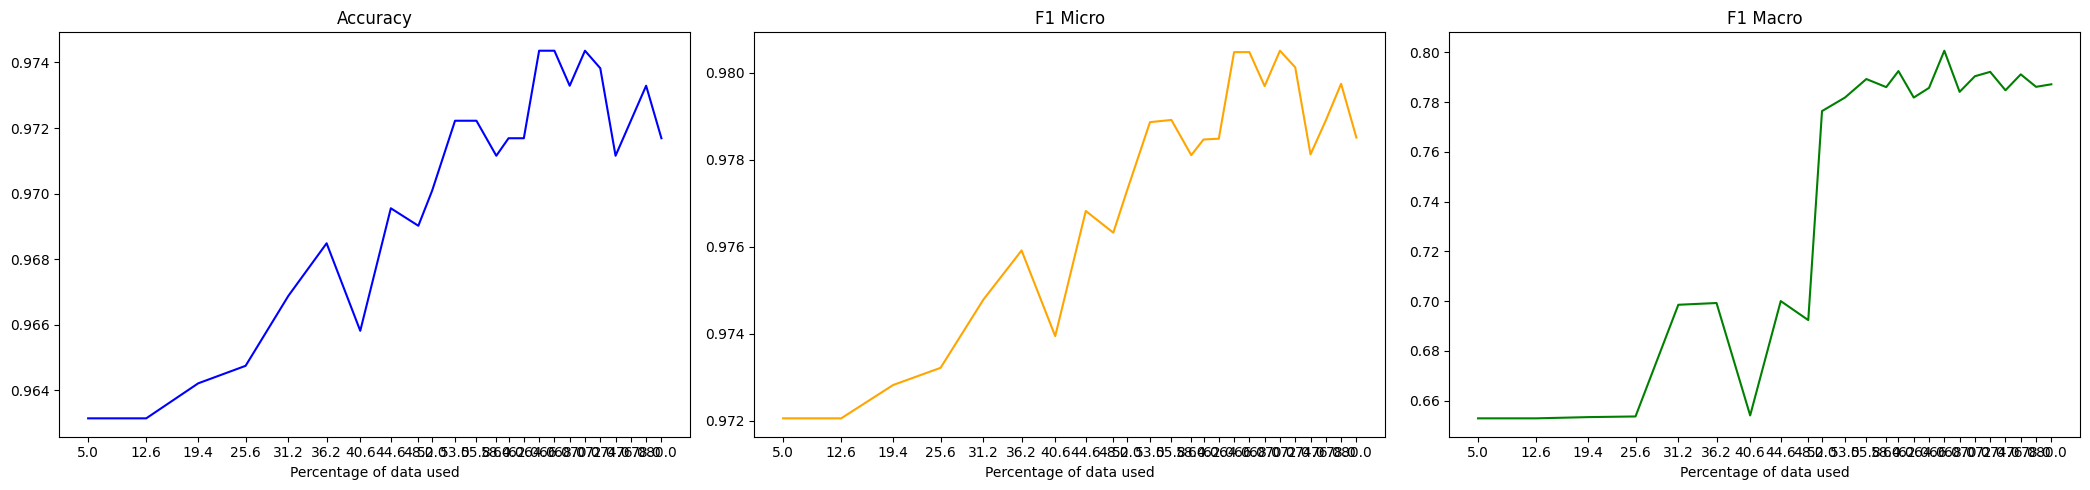

In [18]:
active_learning(seeds[0], 0)

## RUN 2

TRIAL 2
Random seed: [81, 90, 11]
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6098, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3918, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.28, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2134, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2275, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1581, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2152, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1361, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5672, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.359, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2512, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1913, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2132, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1532, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2049, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1264, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5373, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3816, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2713, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2123, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2312, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.154, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2138, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1374, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5159, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2902, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2467, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1846, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1727, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1704, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1639, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1602, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4549, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2606, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2369, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1808, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1676, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1675, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1545, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1523, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6536
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4555, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2761, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2395, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1856, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1736, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.173, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1658, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1702, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4202, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2235, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1912, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1913, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1414, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1699, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 7/10, Train Loss: 0.1552, Accuracy: 0.9599, F1 Micro: 0.969, F1 Macro: 0.6499
Epoch 8/10, Train Loss: 0.1005, Accuracy: 0.9599, F1 Micro: 0.9692, F1 Macro: 0.6502
Epoch 9/10, Train Loss: 0.104, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.6522
Epoch 10/10, Train Loss: 0.0745, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3785, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2106, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1866, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1873, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1379, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1653, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1477, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.656
Epoch 8/10, Train Loss: 0.1064, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.6551
Epoch 9/10, Train Loss: 0.113, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.6541
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3871, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2177, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1949, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1874, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.142, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1677, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.159, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.656
Epoch 8/10, Train Loss: 0.1071, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Epoch 9/10, Train Loss: 0.1214, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.652
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3867, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2271, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1689, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1647, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1829, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1598, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.6543
Epoch 7/10, Train Loss: 0.1496, Accuracy: 0.9599, F1 Micro: 0.9691, F1 Macro: 0.65
Epoch 8/10, Train Loss: 0.133, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.6512
Epoch 9/10, Train Loss: 0.0981, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.7172
Epoch 10/10, Train Loss: 0.0727, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3569, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2232, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1686, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1633, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.177, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Epoch 6/10, Train Loss: 0.1578, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.6551
Epoch 7/10, Train Loss: 0.1531, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.655
Epoch 8/10, Train Loss: 0.1364, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.655
Epoch 9/10, Train Loss: 0.0994, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6532
Epoch 10/10, Train Loss: 0.0751, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3624, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.226, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1715, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1613, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.178, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1637, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6544
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1522, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1354, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.6551
Epoch 9/10, Train Loss: 0.0963, Accuracy: 0.9631, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3607, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2074, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.159, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1852, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1725, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1405, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.6543
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1339, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.6543
Epoch 8/10, Train Loss: 0.0811, Accuracy: 0.9599, F1 Micro: 0.9691, F1 Macro: 0.65
Epoch 9/10, Train Loss: 0.0766, Accuracy: 0.9567, F1 Micro: 0.9666, F1 Macro: 0.649
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3253, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1978, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1561, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1759, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Epoch 5/10, Train Loss: 0.1628, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.6551
Epoch 6/10, Train Loss: 0.1262, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.6522
Epoch 7/10, Train Loss: 0.1228, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.6541
Epoch 8/10, Train Loss: 0.0753, Accuracy: 0.9535, F1 Micro: 0.9641, F1 Macro: 0.6461
Epoch 9/10, Train Loss: 0.0728, Accuracy: 0.9567, F1 Micro: 0.9665, F1 Macro: 0.648
Epoch 10/10, Train Loss: 0.0584, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.6543
Model 2 - Iteratio

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3434, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2092, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1594, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1872, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1778, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1465, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Epoch 7/10, Train Loss: 0.1455, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Epoch 8/10, Train Loss: 0.092, Accuracy: 0.9599, F1 Micro: 0.9692, F1 Macro: 0.6502
Epoch 9/10, Train Loss: 0.0847, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6523
Epoch 10/10, Train Loss: 0.0699, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3343, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2171, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.202, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2086, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1544, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1247, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1067, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7653
Epoch 8/10, Train Loss: 0.0805, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.777
Epoch 9/10, Train Loss: 0.0602, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.778
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3152, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2158, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.198, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2069, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1505, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Epoch 6/10, Train Loss: 0.1202, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6544
Epoch 7/10, Train Loss: 0.1022, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7375
Epoch 8/10, Train Loss: 0.0807, Accuracy: 0.9583, F1 Micro: 0.9678, F1 Macro: 0.743
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0598, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7037
Epoch 10/10, Train Loss: 0.0504, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3087, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2177, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2004, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2149, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1613, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1321, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1233, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.655
Epoch 8/10, Train Loss: 0.0883, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0694, Accuracy: 0.9679, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3159, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1828, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1687, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1557, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Epoch 5/10, Train Loss: 0.1407, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1229, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Epoch 7/10, Train Loss: 0.0924, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.7757
Epoch 8/10, Train Loss: 0.0635, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.753
Epoch 9/10, Train Loss: 0.0583, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7772
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0454, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2986, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.181, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.17, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1492, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1446, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1306, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6552
Epoch 7/10, Train Loss: 0.0971, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.652
Epoch 8/10, Train Loss: 0.0684, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7449
Epoch 9/10, Train Loss: 0.0574, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7386
Epoch 10/10, Train Loss: 0.0418, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.31, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1877, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1731, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.159, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1527, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6552
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1398, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6552
Epoch 7/10, Train Loss: 0.1013, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.7167
Epoch 8/10, Train Loss: 0.0714, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7552
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0651, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7209
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3149, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1939, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1807, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1507, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.655
Epoch 5/10, Train Loss: 0.1265, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.652
Epoch 6/10, Train Loss: 0.1063, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.652
Epoch 7/10, Train Loss: 0.0838, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.754
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0605, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.778
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0452, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7651
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2927, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1922, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1791, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 4/10, Train Loss: 0.1493, Accuracy: 0.9615, F1 Micro: 0.9703, F1 Macro: 0.6509
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1285, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.6551
Epoch 6/10, Train Loss: 0.1082, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6541
Epoch 7/10, Train Loss: 0.0874, Accuracy: 0.9599, F1 Micro: 0.9697, F1 Macro: 0.7333
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0587, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7493
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0446, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.779
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.294, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1939, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1824, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1549, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.6543
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1345, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6552
Epoch 6/10, Train Loss: 0.1213, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.6551
Epoch 7/10, Train Loss: 0.1028, Accuracy: 0.9583, F1 Micro: 0.9683, F1 Macro: 0.7128
Epoch 8/10, Train Loss: 0.07, Accuracy: 0.9567, F1 Micro: 0.9672, F1 Macro: 0.6836
Epoch 9/10, Train Loss: 0.0481, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6552
Epoch 10/10, Train Loss: 0.0485, Accuracy: 0.9599, F1 Micro: 0.9692, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3069, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1831, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1706, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1459, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6544
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1292, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.7672
Epoch 6/10, Train Loss: 0.0912, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7874
Epoch 7/10, Train Loss: 0.0666, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.746
Epoch 8/10, Train Loss: 0.0512, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.778
Epoch 9/10, Train Loss: 0.0383, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7881
Epoch 10/10, Train Loss: 0.0307, Accuracy: 0.9712, F1 Micro: 0.9781, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2863, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1818, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1657, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1423, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6544
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1255, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.6561
Epoch 6/10, Train Loss: 0.0906, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.747
Epoch 7/10, Train Loss: 0.0678, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7642
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0545, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7394
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0364, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7394
Highe

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2906, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1831, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1708, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1511, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1521, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6552
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1134, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6552
Epoch 7/10, Train Loss: 0.0825, Accuracy: 0.9631, F1 Micro: 0.9723, F1 Macro: 0.7441
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0585, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0396, Accuracy: 0.9696, F1 Mic

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.309, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1703, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1672, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1438, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.655
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1397, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7782
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.081, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7663
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.069, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7802
Epoch 8/10, Train Loss: 0.0552, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7566
Epoch 9/10, Train Loss: 0.0473, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.767
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2901, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1679, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1604, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Epoch 4/10, Train Loss: 0.1376, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.6519
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1353, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.656
Epoch 6/10, Train Loss: 0.0832, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7386
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0719, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7663
Epoch 8/10, Train Loss: 0.0528, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7362
Epoch 9/10, Train Loss: 0.0467, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7206
Epoch 10/10, Train Loss: 0.0333, Accuracy: 0.9696, F1 Micro: 0.9767, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.29, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1705, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.164, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1474, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6533
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.149, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.6541
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0991, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6552
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0805, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6552
Epoch 8/10, Train Loss: 0.0559, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7644
Epoch 9/10, Train Loss: 0.0477, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7632
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3049, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1809, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1674, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1592, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6532
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1086, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.6541
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0817, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.767
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0666, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.798
Epoch 8/10, Train Loss: 0.0628, Accuracy: 0.9583, F1 Micro: 0.9678, F1 Macro: 0.7587
Epoch 9/10, Train Loss: 0.0403, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7971
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2876, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1787, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1617, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Epoch 4/10, Train Loss: 0.1521, Accuracy: 0.9599, F1 Micro: 0.969, F1 Macro: 0.6499
Epoch 5/10, Train Loss: 0.1099, Accuracy: 0.9663, F1 Micro: 0.9741, F1 Macro: 0.7196
Epoch 6/10, Train Loss: 0.0756, Accuracy: 0.9599, F1 Micro: 0.9693, F1 Macro: 0.7186
Epoch 7/10, Train Loss: 0.0645, Accuracy: 0.9631, F1 Micro: 0.9722, F1 Macro: 0.7275
Epoch 8/10, Train Loss: 0.0659, Accuracy: 0.9663, F1 Micro: 0.9741, F1 Macro: 0.7196
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0359, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.8656
Epoch 10/10, Train Loss: 0.0286, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7097
Model 2 - Iteratio

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2915, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1798, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1686, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.17, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6533
Epoch 5/10, Train Loss: 0.1302, Accuracy: 0.9631, F1 Micro: 0.9715, F1 Macro: 0.6517
Epoch 6/10, Train Loss: 0.1066, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.7342
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0795, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.6543
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.072, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.778
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0365, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.8219
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2753, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1784, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1562, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Epoch 4/10, Train Loss: 0.1427, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.6543
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1064, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.797
Epoch 6/10, Train Loss: 0.0871, Accuracy: 0.9615, F1 Micro: 0.9702, F1 Macro: 0.7597
Epoch 7/10, Train Loss: 0.064, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7754
Epoch 8/10, Train Loss: 0.0391, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7791
Epoch 9/10, Train Loss: 0.0391, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7791
Epoch 10/10, Train Loss: 0.0285, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7875
Model 1 - Iteration 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2586, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1773, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1518, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1437, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.6561
Epoch 5/10, Train Loss: 0.1027, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7197
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0801, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.7671
Epoch 7/10, Train Loss: 0.0631, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7969
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0394, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.798
Epoch 9/10, Train Loss: 0.0432, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7662
Epoch 10/10, Train Loss: 0.0304, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2575, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1777, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.158, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1495, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.6562
Epoch 5/10, Train Loss: 0.1165, Accuracy: 0.9599, F1 Micro: 0.9691, F1 Macro: 0.65
Epoch 6/10, Train Loss: 0.089, Accuracy: 0.9599, F1 Micro: 0.9689, F1 Macro: 0.7585
Epoch 7/10, Train Loss: 0.0659, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.6543
Epoch 8/10, Train Loss: 0.0455, Accuracy: 0.9647, F1 Micro: 0.9733, F1 Macro: 0.7567
Epoch 9/10, Train Loss: 0.0399, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7635
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0266, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2926, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1793, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1761, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1446, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6552
Epoch 5/10, Train Loss: 0.1131, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.7177
Epoch 6/10, Train Loss: 0.0869, Accuracy: 0.9679, F1 Micro: 0.9753, F1 Macro: 0.7946
Epoch 7/10, Train Loss: 0.0624, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7651
Epoch 8/10, Train Loss: 0.0465, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7852
Epoch 9/10, Train Loss: 0.0302, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7743
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0328, Accuracy: 0.9696, F1 Micro: 0.9768, F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2793, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1785, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1709, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Epoch 4/10, Train Loss: 0.1387, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.6541
Epoch 5/10, Train Loss: 0.1132, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.744
Epoch 6/10, Train Loss: 0.0875, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.743
Epoch 7/10, Train Loss: 0.0638, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.763
Epoch 8/10, Train Loss: 0.0492, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.743
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0311, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.797
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0329, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.278, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1807, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1785, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.147, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6552
Epoch 5/10, Train Loss: 0.1254, Accuracy: 0.9615, F1 Micro: 0.9703, F1 Macro: 0.6509
Epoch 6/10, Train Loss: 0.0986, Accuracy: 0.9663, F1 Micro: 0.9741, F1 Macro: 0.7196
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0693, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7789
Epoch 8/10, Train Loss: 0.0548, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7769
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0322, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.797
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2845, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1838, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1766, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1473, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.6551
Epoch 5/10, Train Loss: 0.1036, Accuracy: 0.9615, F1 Micro: 0.9702, F1 Macro: 0.7163
Epoch 6/10, Train Loss: 0.0852, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.774
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0604, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7793
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0382, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7981
Epoch 9/10, Train Loss: 0.0305, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7966
Epoch 10/10, Train Loss: 0.028, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.266, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1817, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1735, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1435, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6532
Epoch 5/10, Train Loss: 0.0987, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.734
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0843, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.781
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0602, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.8042
Epoch 8/10, Train Loss: 0.0393, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.7773
Epoch 9/10, Train Loss: 0.0293, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.778
Epoch 10/10, Train Loss: 0.0315, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2687, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.181, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1762, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1536, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.6543
Epoch 5/10, Train Loss: 0.1125, Accuracy: 0.9615, F1 Micro: 0.9702, F1 Macro: 0.7597
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0884, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.746
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0627, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.746
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.041, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7654
Epoch 9/10, Train Loss: 0.029, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7782
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2788, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1832, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.165, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 4/10, Train Loss: 0.1403, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.6522
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1146, Accuracy: 0.9663, F1 Micro: 0.9741, F1 Macro: 0.7937
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0724, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7989
Epoch 7/10, Train Loss: 0.0532, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7662
Epoch 8/10, Train Loss: 0.0384, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7949
Epoch 9/10, Train Loss: 0.039, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7893
Epoch 10/10, Train Loss: 0.0238, Accuracy: 0.9728, F1 Micro: 0.9792, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2626, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.183, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1629, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Epoch 4/10, Train Loss: 0.1342, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7197
Epoch 5/10, Train Loss: 0.1116, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.777
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0671, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7681
Epoch 7/10, Train Loss: 0.0561, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7483
Epoch 8/10, Train Loss: 0.0369, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7781
Epoch 9/10, Train Loss: 0.0341, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7743
Epoch 10/10, Train Loss: 0.0231, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7651
Model 2 - Iteration

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2655, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1834, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1678, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1504, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.6562
Epoch 5/10, Train Loss: 0.1327, Accuracy: 0.9615, F1 Micro: 0.9703, F1 Macro: 0.7165
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.08, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7981
Epoch 7/10, Train Loss: 0.0589, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7672
Epoch 8/10, Train Loss: 0.0406, Accuracy: 0.9696, F1 Micro: 0.9766, F1 Macro: 0.7788
Epoch 9/10, Train Loss: 0.0351, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.8033
Epoch 10/10, Train Loss: 0.0245, Accuracy: 0.9663, F1 Micro: 0.9746, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2892, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1946, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.172, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1324, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7811
Epoch 5/10, Train Loss: 0.0941, Accuracy: 0.9663, F1 Micro: 0.974, F1 Macro: 0.7936
Epoch 6/10, Train Loss: 0.0863, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.797
Epoch 7/10, Train Loss: 0.0563, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7586
Epoch 8/10, Train Loss: 0.0506, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.796
Epoch 9/10, Train Loss: 0.0289, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7752
Epoch 10/10, Train Loss: 0.0254, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7662
Model 1 - Iteration 32

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2732, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1918, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1687, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1255, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7107
Epoch 5/10, Train Loss: 0.0961, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.763
Epoch 6/10, Train Loss: 0.0818, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7566
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0556, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7586
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0499, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7884
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0293, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.797
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.279, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1915, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1743, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1383, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.6551
Epoch 5/10, Train Loss: 0.1252, Accuracy: 0.9663, F1 Micro: 0.9741, F1 Macro: 0.6539
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1029, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7884
Epoch 7/10, Train Loss: 0.0652, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7662
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0528, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.798
Epoch 9/10, Train Loss: 0.0302, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7801
Epoch 10/10, Train Loss: 0.0273, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.27, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.183, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1737, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1358, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7587
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1123, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7959
Epoch 6/10, Train Loss: 0.0685, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.7925
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.052, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7959
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0389, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.8197
Epoch 9/10, Train Loss: 0.0338, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.797
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2546, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1805, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1641, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.6562
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1286, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7561
Epoch 5/10, Train Loss: 0.1048, Accuracy: 0.9599, F1 Micro: 0.9691, F1 Macro: 0.7898
Epoch 6/10, Train Loss: 0.0641, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7949
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0502, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.7978
Epoch 8/10, Train Loss: 0.0412, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7949
Epoch 9/10, Train Loss: 0.0353, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7978
Epoch 10/10, Train Loss: 0.0282, Accuracy: 0.9647, F1 Micro: 0.9733, F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2581, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1823, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1767, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1394, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7505
Epoch 5/10, Train Loss: 0.1181, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.7908
Epoch 6/10, Train Loss: 0.0729, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.7919
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0549, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7971
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0407, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7989
Epoch 9/10, Train Loss: 0.035, Accuracy: 0.9647, F1 Micro: 0.9733, F1 Macro: 0.746
Epoch 10/10, Train Loss: 0.024, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2669, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1767, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1635, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6532
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1429, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.798
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0924, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7982
Epoch 6/10, Train Loss: 0.068, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.798
Epoch 7/10, Train Loss: 0.0521, Accuracy: 0.9712, F1 Micro: 0.9778, F1 Macro: 0.7966
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0448, Accuracy: 0.9744, F1 Micro: 0.9804, F1 Macro: 0.7987
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0291, Accuracy: 0.976, F1 Micro: 0.9816, F1 Macro: 0.7997
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2518, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1746, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 3/10, Train Loss: 0.1552, Accuracy: 0.9599, F1 Micro: 0.9689, F1 Macro: 0.6497
Epoch 4/10, Train Loss: 0.1503, Accuracy: 0.9599, F1 Micro: 0.9689, F1 Macro: 0.6497
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0943, Accuracy: 0.9728, F1 Micro: 0.9794, F1 Macro: 0.7895
Epoch 6/10, Train Loss: 0.0703, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7672
Epoch 7/10, Train Loss: 0.0511, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7633
Epoch 8/10, Train Loss: 0.0446, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7653
Epoch 9/10, Train Loss: 0.0289, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.743
Epoch 10/10, Train Loss: 0.0226, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7551
Model 2 - Iteration 340: Accuracy: 0.9728, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2564, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1765, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1643, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Epoch 4/10, Train Loss: 0.1537, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7189
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1022, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7673
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0693, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7989
Epoch 7/10, Train Loss: 0.0504, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7789
Epoch 8/10, Train Loss: 0.0437, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.796
Epoch 9/10, Train Loss: 0.0279, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7793
Epoch 10/10, Train Loss: 0.0202, Accuracy: 0.9696, F1 Micro: 0.9769, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2539, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1829, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.182, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1171, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7763
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1029, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.7978
Epoch 6/10, Train Loss: 0.0656, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7662
Epoch 7/10, Train Loss: 0.0409, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.78
Epoch 8/10, Train Loss: 0.0353, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7672
Epoch 9/10, Train Loss: 0.0254, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7671
Epoch 10/10, Train Loss: 0.0221, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2398, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1821, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1764, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1176, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7471
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0945, Accuracy: 0.976, F1 Micro: 0.9817, F1 Macro: 0.7998
Epoch 6/10, Train Loss: 0.0639, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7989
Epoch 7/10, Train Loss: 0.0486, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7449
Epoch 8/10, Train Loss: 0.0384, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7595
Epoch 9/10, Train Loss: 0.0238, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7781
Epoch 10/10, Train Loss: 0.023, Accuracy: 0.9728, F1 Micro: 0.9793, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2408, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1838, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1856, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1309, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6552
Epoch 5/10, Train Loss: 0.108, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.7179
Epoch 6/10, Train Loss: 0.0833, Accuracy: 0.9663, F1 Micro: 0.9746, F1 Macro: 0.7553
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.051, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7989
Epoch 8/10, Train Loss: 0.0415, Accuracy: 0.9631, F1 Micro: 0.9723, F1 Macro: 0.7505
Epoch 9/10, Train Loss: 0.0262, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.778
Epoch 10/10, Train Loss: 0.0245, Accuracy: 0.9696, F1 Micro: 0.9769, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.256, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1832, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1622, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1208, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.7978
Epoch 5/10, Train Loss: 0.0964, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7801
Epoch 6/10, Train Loss: 0.0595, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7948
Epoch 7/10, Train Loss: 0.054, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.799
Epoch 8/10, Train Loss: 0.0422, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.7759
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0284, Accuracy: 0.9744, F1 Micro: 0.9804, F1 Macro: 0.7997
Epoch 10/10, Train Loss: 0.0218, Accuracy: 0.9712, F1 Micro: 0.978, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2432, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1808, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1605, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.6541
Epoch 4/10, Train Loss: 0.1249, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.7187
Epoch 5/10, Train Loss: 0.0959, Accuracy: 0.9599, F1 Micro: 0.9693, F1 Macro: 0.7533
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0588, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7959
Epoch 7/10, Train Loss: 0.0526, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7585
Epoch 8/10, Train Loss: 0.0437, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7578
Epoch 9/10, Train Loss: 0.0292, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7751
Epoch 10/10, Train Loss: 0.0225, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7577
Model 2 - Iterati

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2425, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1831, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.166, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 4/10, Train Loss: 0.1378, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.652
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.11, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7949
Epoch 6/10, Train Loss: 0.0659, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7952
Epoch 7/10, Train Loss: 0.0559, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7632
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0439, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7799
Epoch 9/10, Train Loss: 0.0298, Accuracy: 0.9599, F1 Micro: 0.9692, F1 Macro: 0.761
Epoch 10/10, Train Loss: 0.0218, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2558, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1689, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1638, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1103, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7762
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0795, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7812
Epoch 6/10, Train Loss: 0.0635, Accuracy: 0.9679, F1 Micro: 0.9753, F1 Macro: 0.7946
Epoch 7/10, Train Loss: 0.0545, Accuracy: 0.9615, F1 Micro: 0.9705, F1 Macro: 0.7719
Epoch 8/10, Train Loss: 0.0352, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7967
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.032, Accuracy: 0.9744, F1 Micro: 0.9804, F1 Macro: 0.8215
Higher F1 achieved, saving model
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2434, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.168, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1619, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Epoch 4/10, Train Loss: 0.1152, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.7622
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0829, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.778
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0669, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7672
Epoch 7/10, Train Loss: 0.0547, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7769
Epoch 8/10, Train Loss: 0.0323, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7762
Epoch 9/10, Train Loss: 0.0284, Accuracy: 0.9647, F1 Micro: 0.9735, F1 Macro: 0.7506
Epoch 10/10, Train Loss: 0.0274, Accuracy: 0.9696, F1 Micro: 0.9768, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2451, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1685, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1677, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1253, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7643
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.095, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7663
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0698, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7967
Epoch 7/10, Train Loss: 0.059, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7967
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0351, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.781
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0302, Accuracy: 0.9744, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2534, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1531, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1442, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1262, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.798
Epoch 5/10, Train Loss: 0.0994, Accuracy: 0.9696, F1 Micro: 0.9766, F1 Macro: 0.7958
Epoch 6/10, Train Loss: 0.0652, Accuracy: 0.9679, F1 Micro: 0.9752, F1 Macro: 0.7943
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0531, Accuracy: 0.976, F1 Micro: 0.9817, F1 Macro: 0.8227
Epoch 8/10, Train Loss: 0.0367, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7662
Epoch 9/10, Train Loss: 0.0286, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.7773
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0253, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2403, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1508, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.142, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.6562
Epoch 4/10, Train Loss: 0.1289, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.6512
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1023, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7811
Epoch 6/10, Train Loss: 0.0669, Accuracy: 0.9599, F1 Micro: 0.9692, F1 Macro: 0.7499
Epoch 7/10, Train Loss: 0.057, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7577
Epoch 8/10, Train Loss: 0.0352, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7642
Epoch 9/10, Train Loss: 0.0297, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7671
Epoch 10/10, Train Loss: 0.0279, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7577
Model 2 - Iteration

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2467, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1519, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1486, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 4/10, Train Loss: 0.1351, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.6519
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1108, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7981
Epoch 6/10, Train Loss: 0.0681, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7967
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.055, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7981
Epoch 8/10, Train Loss: 0.0326, Accuracy: 0.9535, F1 Micro: 0.9653, F1 Macro: 0.7187
Epoch 9/10, Train Loss: 0.0236, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7981
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0244, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.243, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1624, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1348, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 4/10, Train Loss: 0.1142, Accuracy: 0.9615, F1 Micro: 0.971, F1 Macro: 0.7384
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.093, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7801
Epoch 6/10, Train Loss: 0.067, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.78
Epoch 7/10, Train Loss: 0.046, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.798
Epoch 8/10, Train Loss: 0.0383, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.766
Epoch 9/10, Train Loss: 0.0324, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7459
Epoch 10/10, Train Loss: 0.0197, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7622
Model 1 - Iteration 390: Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2273, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1587, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.129, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1143, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7394
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0906, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7512
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.066, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7671
Epoch 7/10, Train Loss: 0.0434, Accuracy: 0.9647, F1 Micro: 0.9733, F1 Macro: 0.7576
Epoch 8/10, Train Loss: 0.0376, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7511
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.033, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.7978
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2329, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1612, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1378, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1274, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6552
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1139, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7661
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.073, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7978
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0491, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.799
Epoch 8/10, Train Loss: 0.0421, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7679
Epoch 9/10, Train Loss: 0.0322, Accuracy: 0.9663, F1 Micro: 0.9741, F1 Macro: 0.7946
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2447, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1451, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1519, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1118, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7989
Epoch 5/10, Train Loss: 0.0924, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7969
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0624, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7989
Epoch 7/10, Train Loss: 0.0429, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7951
Epoch 8/10, Train Loss: 0.0403, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.797
Epoch 9/10, Train Loss: 0.0261, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.7628
Epoch 10/10, Train Loss: 0.022, Accuracy: 0.9712, F1 Micro: 0.978, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2338, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1428, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1463, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1084, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.7236
Epoch 5/10, Train Loss: 0.09, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7338
Epoch 6/10, Train Loss: 0.0617, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7595
Epoch 7/10, Train Loss: 0.0451, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7661
Epoch 8/10, Train Loss: 0.0385, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.762
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.023, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.8041
Epoch 10/10, Train Loss: 0.0228, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2368, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1461, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1558, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1145, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.6543
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0924, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7772
Epoch 6/10, Train Loss: 0.0655, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7661
Epoch 7/10, Train Loss: 0.0384, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7512
Epoch 8/10, Train Loss: 0.0359, Accuracy: 0.9663, F1 Micro: 0.9741, F1 Macro: 0.7937
Epoch 9/10, Train Loss: 0.0246, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7948
Epoch 10/10, Train Loss: 0.0212, Accuracy: 0.9679, F1 Micro: 0.9756, F

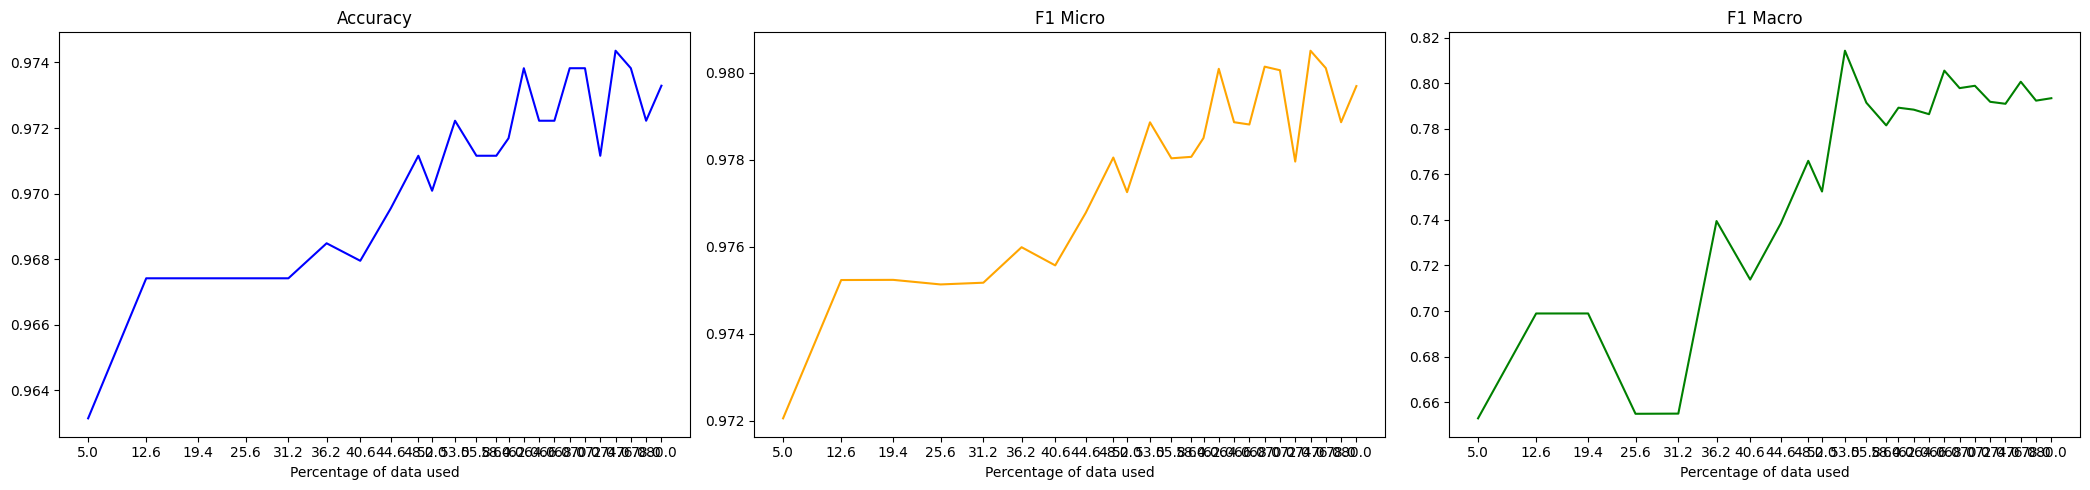

In [ ]:
active_learning(seeds[1], 1)

## RUN 3

TRIAL 3
Random seed: [14, 7, 33]
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5339, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.361, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2712, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2079, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2244, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1625, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2034, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1394, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6345, Accuracy: 0.9263, F1 Micro: 0.9407, F1 Macro: 0.6225
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3936, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2767, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2143, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2256, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.161, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2104, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1331, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.535, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3536, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.265, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2017, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2273, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1566, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2122, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1356, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4419, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2472, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2084, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1504, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1312, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1582, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1017, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1071, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5084, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2584, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2137, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.148, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1299, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1528, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0993, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1057, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4137, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2393, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2065, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1445, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.135, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1565, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1035, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1096, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3845, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1983, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1864, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1309, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1334, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1492, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 7/10, Train Loss: 0.1304, Accuracy: 0.9599, F1 Micro: 0.969, F1 Macro: 0.6499
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1003, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6544
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1234, Accuracy: 0.9663, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4247, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1961, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1842, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.127, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1328, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.144, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1212, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0794, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.799
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3698, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1934, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1865, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1307, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.135, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1581, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.145, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1141, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3522, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1868, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1575, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1439, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1476, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1499, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1168, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0983, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.6562
Epoch 9/10, Train Loss: 0.0939, Accuracy: 0.9647, F1 Mic

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3856, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.187, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1563, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1423, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1427, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1368, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1055, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.6568
Epoch 8/10, Train Loss: 0.0839, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7877
Epoch 9/10, Train Loss: 0.0725, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7656
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3441, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1858, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1578, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1412, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1492, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.154, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1247, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.6562
Epoch 8/10, Train Loss: 0.1176, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6552
Epoch 9/10, Train Loss: 0.1104, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6552
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3295, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1785, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1803, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1589, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1565, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1502, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.6541
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1232, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.6569
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1061, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.6569
Epoch 9/10, Train Loss: 0.0689, Accuracy: 0.9631, F1 Mic

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3551, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1784, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1771, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1598, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1501, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 6/10, Train Loss: 0.1491, Accuracy: 0.9615, F1 Micro: 0.9703, F1 Macro: 0.6509
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1186, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1012, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7662
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0652, Accuracy: 0.9712, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3155, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1754, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1812, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1595, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1585, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1573, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1245, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.6551
Epoch 8/10, Train Loss: 0.1088, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7198
Epoch 9/10, Train Loss: 0.0748, Accuracy: 0.9615, F1 Micro: 0.9705, F1 Macro: 0.717
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2979, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1958, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1513, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1656, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1649, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1303, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.655
Epoch 7/10, Train Loss: 0.0805, Accuracy: 0.9551, F1 Micro: 0.9652, F1 Macro: 0.6467
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0764, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7661
Epoch 9/10, Train Loss: 0.0686, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7992
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.322, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1929, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1523, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1608, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1616, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.127, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0798, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7662
Epoch 8/10, Train Loss: 0.0717, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7551
Epoch 9/10, Train Loss: 0.0694, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7512
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.288, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1956, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1517, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1682, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1744, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1416, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.6562
Epoch 7/10, Train Loss: 0.0954, Accuracy: 0.9567, F1 Micro: 0.9665, F1 Macro: 0.6478
Epoch 8/10, Train Loss: 0.0999, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.6561
Epoch 9/10, Train Loss: 0.093, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.7622
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2888, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1739, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1678, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1585, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.135, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1164, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6552
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1049, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.7974
Epoch 8/10, Train Loss: 0.0712, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7874
Epoch 9/10, Train Loss: 0.0538, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7671
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3155, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1728, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1644, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1585, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1281, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.6562
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1007, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.7681
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0918, Accuracy: 0.9728, F1 Micro: 0.9794, F1 Macro: 0.7782
Epoch 8/10, Train Loss: 0.064, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7751
Epoch 9/10, Train Loss: 0.0622, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.7419
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2812, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1732, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1687, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1612, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1361, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.6561
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1202, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.6561
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1194, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.6561
Epoch 8/10, Train Loss: 0.0848, Accuracy: 0.9535, F1 Micro: 0.9639, F1 Macro: 0.6456
Epoch 9/10, Train Loss: 0.0663, Accuracy: 0.9599, F1 Micro: 0.9692, F1 Macro: 0.7332
High

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2683, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1844, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1628, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1583, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 5/10, Train Loss: 0.1448, Accuracy: 0.9583, F1 Micro: 0.9677, F1 Macro: 0.6488
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1096, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7204
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0872, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.8031
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0553, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.798
Epoch 9/10, Train Loss: 0.0513, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.797
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2911, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1805, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1596, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1567, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1385, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6552
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0936, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.8204
Epoch 7/10, Train Loss: 0.0777, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7511
Epoch 8/10, Train Loss: 0.0477, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7584
Epoch 9/10, Train Loss: 0.0549, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.767
Epoch 10/10, Train Loss: 0.0468, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2625, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1815, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.163, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1628, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1476, Accuracy: 0.9663, F1 Micro: 0.9741, F1 Macro: 0.6539
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1139, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6552
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1048, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.656
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0649, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7763
Epoch 9/10, Train Loss: 0.058, Accuracy: 0.9663, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2777, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1728, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1699, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1684, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1379, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.6562
Epoch 6/10, Train Loss: 0.1209, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.6561
Epoch 7/10, Train Loss: 0.0907, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7648
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0578, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.7672
Epoch 9/10, Train Loss: 0.0489, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7503
Epoch 10/10, Train Loss: 0.0506, Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2959, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1732, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1635, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1575, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1119, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.797
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0829, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7522
Epoch 7/10, Train Loss: 0.0666, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7596
Epoch 8/10, Train Loss: 0.0519, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7586
Epoch 9/10, Train Loss: 0.0449, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7586
Epoch 10/10, Train Loss: 0.0515, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2705, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1753, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1707, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1779, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1486, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.657
Epoch 6/10, Train Loss: 0.1264, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.656
Epoch 7/10, Train Loss: 0.101, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7795
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0593, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7981
Epoch 9/10, Train Loss: 0.048, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.777
Epoch 10/10, Train Loss: 0.0497, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.268, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1697, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1647, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1452, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.657
Epoch 5/10, Train Loss: 0.1649, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6552
Epoch 6/10, Train Loss: 0.0896, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0716, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7981
Epoch 8/10, Train Loss: 0.0529, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7086
Epoch 9/10, Train Loss: 0.0461, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.6561
Epoch 10/10, Train Loss: 0.0356, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2877, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1699, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1635, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1372, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.6541
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1434, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7512
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0727, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7568
Epoch 7/10, Train Loss: 0.0638, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7663
Epoch 8/10, Train Loss: 0.0522, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.749
Epoch 9/10, Train Loss: 0.0478, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7521
Epoch 10/10, Train Loss: 0.0361, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.26, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1689, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1633, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1496, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1782, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.108, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7801
Epoch 7/10, Train Loss: 0.0865, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7483
Epoch 8/10, Train Loss: 0.0583, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7556
Epoch 9/10, Train Loss: 0.049, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7644
Epoch 10/10, Train Loss: 0.0348, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2849, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.178, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1824, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1577, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.6541
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1225, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.779
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0877, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7884
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0607, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7812
Epoch 8/10, Train Loss: 0.0548, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.7673
Epoch 9/10, Train Loss: 0.0432, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.7773
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3032, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.177, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1802, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1465, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7811
Epoch 5/10, Train Loss: 0.1016, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7457
Epoch 6/10, Train Loss: 0.0818, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7466
Epoch 7/10, Train Loss: 0.0612, Accuracy: 0.9647, F1 Micro: 0.9735, F1 Macro: 0.7506
Epoch 8/10, Train Loss: 0.0604, Accuracy: 0.9663, F1 Micro: 0.9746, F1 Macro: 0.7521
Epoch 9/10, Train Loss: 0.0432, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7521
Epoch 10/10, Train Loss: 0.0339, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7594
Model 2 - Iteratio

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2762, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1779, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1831, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1598, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1317, Accuracy: 0.9696, F1 Micro: 0.9766, F1 Macro: 0.765
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1007, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7801
Epoch 7/10, Train Loss: 0.063, Accuracy: 0.9647, F1 Micro: 0.9735, F1 Macro: 0.7741
Epoch 8/10, Train Loss: 0.0614, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7671
Epoch 9/10, Train Loss: 0.0445, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7651
Epoch 10/10, Train Loss: 0.0329, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2643, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1736, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1583, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1656, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.6562
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1382, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7117
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0974, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7762
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0558, Accuracy: 0.9728, F1 Micro: 0.9794, F1 Macro: 0.7895
Epoch 8/10, Train Loss: 0.0485, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7884
Epoch 9/10, Train Loss: 0.0432, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7751
Epoc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2805, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1712, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1553, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1553, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.8041
Epoch 5/10, Train Loss: 0.1175, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.7672
Epoch 6/10, Train Loss: 0.0786, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7893
Epoch 7/10, Train Loss: 0.0478, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.768
Epoch 8/10, Train Loss: 0.0433, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7584
Epoch 9/10, Train Loss: 0.043, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7679
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0387, Accuracy: 0.9744, F1 Micro: 0.9805, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2546, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1737, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1584, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1779, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1477, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7802
Epoch 6/10, Train Loss: 0.1035, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7661
Epoch 7/10, Train Loss: 0.057, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7671
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0474, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7893
Epoch 9/10, Train Loss: 0.045, Accuracy: 0.9647, F1 Micro: 0.9733, F1 Macro: 0.7661
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2747, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1805, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1754, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1444, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6532
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1233, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7489
Epoch 6/10, Train Loss: 0.0886, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.7927
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0687, Accuracy: 0.9696, F1 Micro: 0.9766, F1 Macro: 0.7956
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0532, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7798
Epoch 9/10, Train Loss: 0.0364, Accuracy: 0.9647, F1 Micro: 0.9733, F1 Macro: 0.746
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2884, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1794, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1699, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1322, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.656
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1157, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.799
Epoch 6/10, Train Loss: 0.0841, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7948
Epoch 7/10, Train Loss: 0.0714, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7553
Epoch 8/10, Train Loss: 0.0555, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7594
Epoch 9/10, Train Loss: 0.0429, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.767
Epoch 10/10, Train Loss: 0.033, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2659, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1801, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1747, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 4/10, Train Loss: 0.145, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.6519
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.129, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7787
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0966, Accuracy: 0.9744, F1 Micro: 0.9803, F1 Macro: 0.7986
Epoch 7/10, Train Loss: 0.0708, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7491
Epoch 8/10, Train Loss: 0.0503, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7493
Epoch 9/10, Train Loss: 0.0374, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7977
Epoch 10/10, Train Loss: 0.0316, Accuracy: 0.9712, F1 Micro: 0.978, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2704, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.189, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1899, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1507, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.654
Epoch 5/10, Train Loss: 0.1231, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.761
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0877, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7875
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0756, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7673
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.063, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.798
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0412, Accuracy: 0.9728, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.286, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1859, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.189, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1414, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.765
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1035, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7762
Epoch 6/10, Train Loss: 0.0796, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7574
Epoch 7/10, Train Loss: 0.0675, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7659
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0552, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7672
Epoch 9/10, Train Loss: 0.0427, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.765
Epoch 10/10, Train Loss: 0.0327, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2629, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1888, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1943, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 4/10, Train Loss: 0.156, Accuracy: 0.9615, F1 Micro: 0.9703, F1 Macro: 0.6509
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1373, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7643
Epoch 6/10, Train Loss: 0.1038, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7512
Epoch 7/10, Train Loss: 0.0819, Accuracy: 0.9663, F1 Micro: 0.9746, F1 Macro: 0.7648
Epoch 8/10, Train Loss: 0.0624, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.746
Epoch 9/10, Train Loss: 0.0429, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7661
Epoch 10/10, Train Loss: 0.0344, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7662
Model 3 - Iteration

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.271, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1781, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1784, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1617, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1303, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.722
Epoch 6/10, Train Loss: 0.0912, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7791
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0564, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.798
Epoch 8/10, Train Loss: 0.0493, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.754
Epoch 9/10, Train Loss: 0.042, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7801
Epoch 10/10, Train Loss: 0.0305, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2816, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1758, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1746, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1453, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7672
Epoch 5/10, Train Loss: 0.1041, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.7618
Epoch 6/10, Train Loss: 0.0772, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7662
Epoch 7/10, Train Loss: 0.0521, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7449
Epoch 8/10, Train Loss: 0.0463, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.767
Epoch 9/10, Train Loss: 0.0397, Accuracy: 0.9647, F1 Micro: 0.9733, F1 Macro: 0.7447
Epoch 10/10, Train Loss: 0.0304, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.767
Model 2 - Iteration 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2635, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.176, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1817, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1705, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1318, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7643
Epoch 6/10, Train Loss: 0.0923, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7754
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0547, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7661
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0484, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7789
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0398, Accuracy: 0.9712, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2678, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.178, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.153, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1304, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.6561
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1114, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.7672
Epoch 6/10, Train Loss: 0.0849, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7762
Epoch 7/10, Train Loss: 0.0551, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7875
Epoch 8/10, Train Loss: 0.0449, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.796
Epoch 9/10, Train Loss: 0.0372, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7773
Epoch 10/10, Train Loss: 0.0321, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2815, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1765, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1495, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1163, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.7672
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.091, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.7672
Epoch 6/10, Train Loss: 0.0781, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7449
Epoch 7/10, Train Loss: 0.0535, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7595
Epoch 8/10, Train Loss: 0.045, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7595
Epoch 9/10, Train Loss: 0.0388, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7439
Epoch 10/10, Train Loss: 0.0365, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2599, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1791, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.157, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1375, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.6541
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1158, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7981
Epoch 6/10, Train Loss: 0.0923, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7671
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0611, Accuracy: 0.9728, F1 Micro: 0.9794, F1 Macro: 0.7782
Epoch 8/10, Train Loss: 0.0471, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7811
Epoch 9/10, Train Loss: 0.0382, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.767
Epoch 10/10, Train Loss: 0.0341, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2466, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1706, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1589, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1522, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.655
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1029, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.798
Epoch 6/10, Train Loss: 0.0818, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7672
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0547, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7989
Epoch 8/10, Train Loss: 0.0482, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7513
Epoch 9/10, Train Loss: 0.0349, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7762
Epoch 10/10, Train Loss: 0.025, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2582, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.167, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1568, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1326, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7576
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0887, Accuracy: 0.9663, F1 Micro: 0.9746, F1 Macro: 0.7513
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0804, Accuracy: 0.9744, F1 Micro: 0.9804, F1 Macro: 0.7987
Epoch 7/10, Train Loss: 0.0572, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.753
Epoch 8/10, Train Loss: 0.0511, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7689
Epoch 9/10, Train Loss: 0.036, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7584
Epoch 10/10, Train Loss: 0.0278, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.24, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1706, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1643, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1643, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1194, Accuracy: 0.9679, F1 Micro: 0.9753, F1 Macro: 0.7946
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1032, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.7808
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0621, Accuracy: 0.9744, F1 Micro: 0.9804, F1 Macro: 0.7818
Epoch 8/10, Train Loss: 0.0517, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7671
Epoch 9/10, Train Loss: 0.0361, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.781
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2367, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1696, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1634, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1287, Accuracy: 0.9679, F1 Micro: 0.9753, F1 Macro: 0.6548
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1008, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7217
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0813, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7761
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0576, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7801
Epoch 8/10, Train Loss: 0.0412, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7762
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0317, Accuracy: 0.9728, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2462, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1653, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1592, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1069, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.8041
Epoch 5/10, Train Loss: 0.0846, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7883
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0743, Accuracy: 0.9776, F1 Micro: 0.9829, F1 Macro: 0.8236
Epoch 7/10, Train Loss: 0.0537, Accuracy: 0.976, F1 Micro: 0.9817, F1 Macro: 0.7998
Epoch 8/10, Train Loss: 0.0392, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7439
Epoch 9/10, Train Loss: 0.0366, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.801
Epoch 10/10, Train Loss: 0.0261, Accuracy: 0.9663, F1 Micro: 0.9745, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2298, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1684, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1675, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1356, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.657
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.113, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7663
Epoch 6/10, Train Loss: 0.0886, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.7917
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0594, Accuracy: 0.976, F1 Micro: 0.9816, F1 Macro: 0.7997
Epoch 8/10, Train Loss: 0.0411, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7448
Epoch 9/10, Train Loss: 0.0338, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7448
Epoch 10/10, Train Loss: 0.0251, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2435, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1803, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1498, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1285, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.7803
Epoch 6/10, Train Loss: 0.0751, Accuracy: 0.9647, F1 Micro: 0.9735, F1 Macro: 0.7451
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0494, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.7818
Epoch 8/10, Train Loss: 0.0448, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7799
Epoch 9/10, Train Loss: 0.0327, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.7759
Epoch 10/10, Train Loss: 0.0256, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2573, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1793, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1438, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1141, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.722
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0908, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7681
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0709, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7781
Epoch 7/10, Train Loss: 0.047, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.775
Epoch 8/10, Train Loss: 0.0455, Accuracy: 0.9728, F1 Micro: 0.9791, F1 Macro: 0.7977
Epoch 9/10, Train Loss: 0.0368, Accuracy: 0.9647, F1 Micro: 0.9733, F1 Macro: 0.7502
Epoch 10/10, Train Loss: 0.0307, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2359, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1823, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1508, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.138, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1118, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7989
Epoch 6/10, Train Loss: 0.0828, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7512
Epoch 7/10, Train Loss: 0.0549, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7584
Epoch 8/10, Train Loss: 0.0476, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7491
Epoch 9/10, Train Loss: 0.0328, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.766
Epoch 10/10, Train Loss: 0.0266, Accuracy: 0.9712, F1 Micro: 0.9781, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2621, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.173, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.149, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1418, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.657
Epoch 5/10, Train Loss: 0.1049, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7852
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0771, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7663
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.046, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7811
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0401, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7811
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0321, Accuracy: 0.9744, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2821, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1701, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1473, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7648
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1214, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.8208
Epoch 5/10, Train Loss: 0.0826, Accuracy: 0.9583, F1 Micro: 0.9678, F1 Macro: 0.7887
Epoch 6/10, Train Loss: 0.0691, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7521
Epoch 7/10, Train Loss: 0.043, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7511
Epoch 8/10, Train Loss: 0.0386, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.768
Epoch 9/10, Train Loss: 0.0352, Accuracy: 0.9647, F1 Micro: 0.9733, F1 Macro: 0.7576
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0261, Accuracy: 0.976, F1 Micro: 0.9817, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2571, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1744, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1534, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1589, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Epoch 5/10, Train Loss: 0.1238, Accuracy: 0.9599, F1 Micro: 0.9689, F1 Macro: 0.7587
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0976, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7672
Epoch 7/10, Train Loss: 0.0557, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7969
Epoch 8/10, Train Loss: 0.0441, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7577
Epoch 9/10, Train Loss: 0.0361, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7651
Epoch 10/10, Train Loss: 0.0277, Accuracy: 0.9679, F1 Micro: 0.9757, F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2507, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1551, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.153, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1415, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.096, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7662
Epoch 6/10, Train Loss: 0.0767, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.6561
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0418, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7801
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0347, Accuracy: 0.9744, F1 Micro: 0.9804, F1 Macro: 0.7988
Epoch 9/10, Train Loss: 0.0305, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7577
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2663, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1565, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.142, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.764
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1179, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.8041
Epoch 5/10, Train Loss: 0.0814, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7402
Epoch 6/10, Train Loss: 0.0741, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.7978
Epoch 7/10, Train Loss: 0.0425, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7773
Epoch 8/10, Train Loss: 0.0394, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.747
Epoch 9/10, Train Loss: 0.0355, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7392
Epoch 10/10, Train Loss: 0.0257, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7689
Model 2 - Iteration 3

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2462, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1568, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1553, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1537, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.655
Epoch 5/10, Train Loss: 0.111, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7643
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0815, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7642
Epoch 7/10, Train Loss: 0.045, Accuracy: 0.9599, F1 Micro: 0.9693, F1 Macro: 0.7711
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0362, Accuracy: 0.976, F1 Micro: 0.9817, F1 Macro: 0.7998
Epoch 9/10, Train Loss: 0.0329, Accuracy: 0.9583, F1 Micro: 0.9682, F1 Macro: 0.8191
Epoch 10/10, Train Loss: 0.0254, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2453, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1597, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1534, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1433, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.6561
Epoch 5/10, Train Loss: 0.1051, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7959
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0742, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7982
Epoch 7/10, Train Loss: 0.0525, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7586
Epoch 8/10, Train Loss: 0.0447, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.797
Epoch 9/10, Train Loss: 0.0335, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.797
Epoch 10/10, Train Loss: 0.0219, Accuracy: 0.9712, F1 Micro: 0.9781, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2585, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.157, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 3/10, Train Loss: 0.146, Accuracy: 0.9583, F1 Micro: 0.9688, F1 Macro: 0.7298
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1214, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7594
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0992, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.7892
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0714, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.799
Epoch 7/10, Train Loss: 0.0559, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.766
Epoch 8/10, Train Loss: 0.046, Accuracy: 0.9631, F1 Micro: 0.9723, F1 Macro: 0.7449
Epoch 9/10, Train Loss: 0.0397, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7771
Epoch 10/10, Train Loss: 0.0273, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2403, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.158, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1578, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1526, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.657
Epoch 5/10, Train Loss: 0.1159, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.7747
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0887, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7982
Epoch 7/10, Train Loss: 0.0659, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7791
Epoch 8/10, Train Loss: 0.0497, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7762
Epoch 9/10, Train Loss: 0.0356, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.781
Epoch 10/10, Train Loss: 0.0239, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2439, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1727, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1679, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1394, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.657
Epoch 5/10, Train Loss: 0.1242, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7661
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0807, Accuracy: 0.9744, F1 Micro: 0.9806, F1 Macro: 0.7903
Epoch 7/10, Train Loss: 0.059, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7989
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.042, Accuracy: 0.976, F1 Micro: 0.9817, F1 Macro: 0.805
Epoch 9/10, Train Loss: 0.0296, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.7894
Epoch 10/10, Train Loss: 0.0237, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2543, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1714, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1651, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.6541
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1207, Accuracy: 0.9663, F1 Micro: 0.9747, F1 Macro: 0.7459
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0994, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7874
Epoch 6/10, Train Loss: 0.062, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7522
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0577, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.767
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0396, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.768
Epoch 9/10, Train Loss: 0.0296, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7491
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2371, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1723, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1733, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1393, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1216, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7811
Epoch 6/10, Train Loss: 0.0806, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7662
Epoch 7/10, Train Loss: 0.0561, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7661
Epoch 8/10, Train Loss: 0.0408, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7586
Epoch 9/10, Train Loss: 0.0355, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7651
Epoch 10/10, Train Loss: 0.0241, Accuracy: 0.9679, F1 Micro: 0.9757, F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2466, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1606, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.146, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1389, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.6561
Epoch 5/10, Train Loss: 0.1046, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0717, Accuracy: 0.9744, F1 Micro: 0.9804, F1 Macro: 0.8215
Epoch 7/10, Train Loss: 0.0564, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7883
Epoch 8/10, Train Loss: 0.046, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.8197
Epoch 9/10, Train Loss: 0.0264, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7586
Epoch 10/10, Train Loss: 0.0285, Accuracy: 0.9728, F1 Micro: 0.9792, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.261, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1591, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1398, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1178, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7514
Epoch 5/10, Train Loss: 0.0949, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7502
Epoch 6/10, Train Loss: 0.0747, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7639
Epoch 7/10, Train Loss: 0.067, Accuracy: 0.9647, F1 Micro: 0.9733, F1 Macro: 0.7502
Epoch 8/10, Train Loss: 0.0501, Accuracy: 0.9663, F1 Micro: 0.9746, F1 Macro: 0.7513
Epoch 9/10, Train Loss: 0.0285, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7501
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0297, Accuracy: 0.976, F1 Micro: 0.9816, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2432, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1619, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.147, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1379, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.6561
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1078, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7227
Epoch 6/10, Train Loss: 0.0708, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.7759
Epoch 7/10, Train Loss: 0.0592, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7651
Epoch 8/10, Train Loss: 0.0477, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.762
Epoch 9/10, Train Loss: 0.0267, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7752
Epoch 10/10, Train Loss: 0.0266, Accuracy: 0.9679, F1 Micro: 0.9755, F1 M

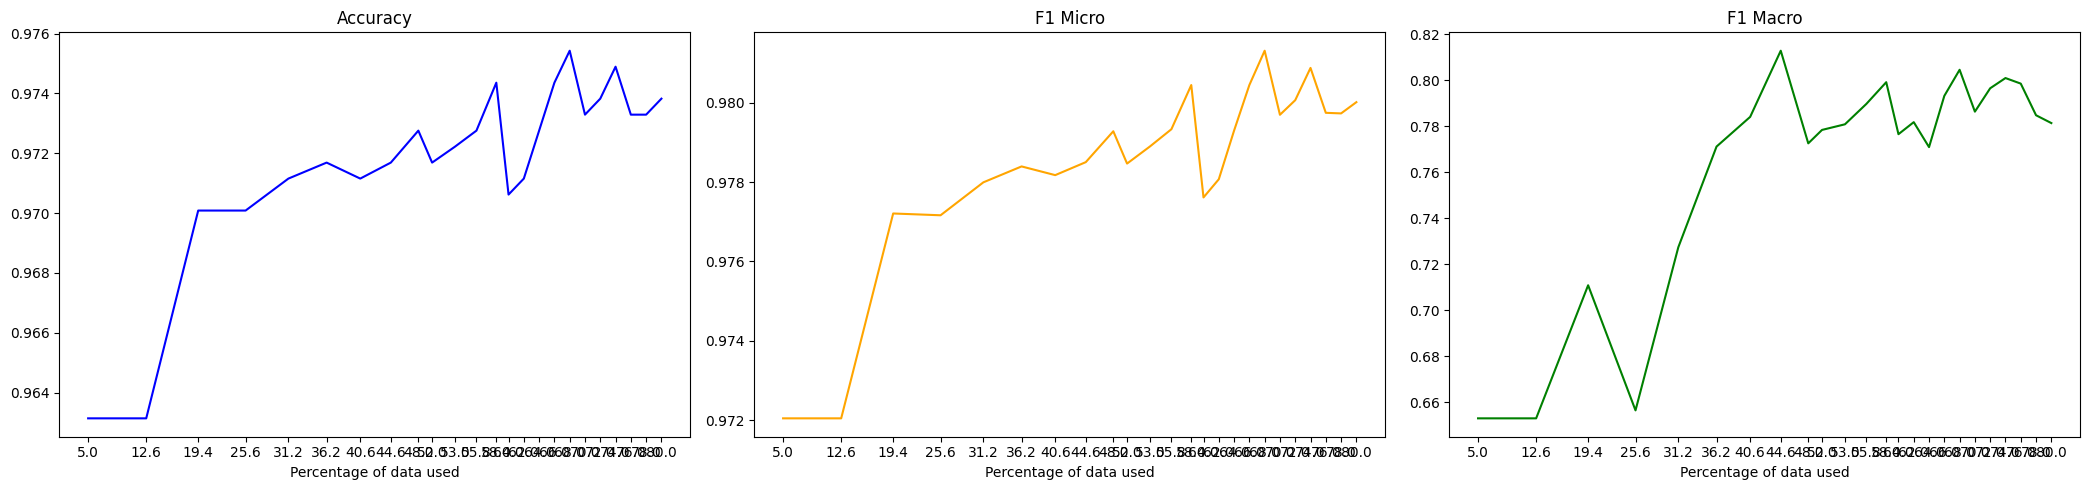

In [ ]:
active_learning(seeds[2], 2)

## RUN 4

TRIAL 4
Random seed: [3, 44, 85]
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5173, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3418, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2503, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1975, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2158, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1534, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1996, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1359, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5685, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3582, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2587, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.197, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2159, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1493, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1968, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1304, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5199, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3337, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2346, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1857, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2179, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1455, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1975, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1299, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4231, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2507, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2084, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1895, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1885, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1909, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1718, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1656, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4652, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2628, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2134, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1901, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.196, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1894, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1653, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1587, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4158, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2492, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2092, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1853, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.192, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1864, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1615, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1622, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3612, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2331, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2012, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1907, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1463, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.16, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1447, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 8/10, Train Loss: 0.1273, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.6528
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0967, Accuracy: 0.9631, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3972, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2369, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.199, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1858, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1446, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1574, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 7/10, Train Loss: 0.1402, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.6526
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1274, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6533
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0982, Accuracy: 0.9663, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3562, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2351, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1877, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1395, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 6/10, Train Loss: 0.1539, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.6528
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1362, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.6541
Epoch 8/10, Train Loss: 0.1153, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6532
Epoch 9/10, Train Loss: 0.0957, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6532
Higher F1 achieved, saving model
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3382, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2129, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.19, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1827, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1827, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1544, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 7/10, Train Loss: 0.1342, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6518
Epoch 8/10, Train Loss: 0.1301, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.6526
Epoch 9/10, Train Loss: 0.1014, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.6528
Epoch 10/10, Train Loss: 0.0859, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3681, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2169, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1875, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1838, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1817, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.147, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1293, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6532
Epoch 8/10, Train Loss: 0.1242, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 9/10, Train Loss: 0.1113, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3324, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2137, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1906, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1809, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1748, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.149, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 7/10, Train Loss: 0.1249, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.652
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1036, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.656
Epoch 9/10, Train Loss: 0.0945, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7219
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3253, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2279, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1873, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1975, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.175, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 6/10, Train Loss: 0.1471, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.651
Epoch 7/10, Train Loss: 0.1409, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6525
Epoch 8/10, Train Loss: 0.1071, Accuracy: 0.9583, F1 Micro: 0.9681, F1 Macro: 0.6496
Epoch 9/10, Train Loss: 0.083, Accuracy: 0.9567, F1 Micro: 0.9667, F1 Macro: 0.6484
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0468, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3428, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2272, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1897, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1941, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1688, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1372, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1399, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6532
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1035, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6553
Epoch 9/10, Train Loss: 0.0962, Accuracy: 0.9647, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3262, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2277, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.186, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1921, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.169, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1279, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Epoch 7/10, Train Loss: 0.1262, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.094, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7116
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0788, Accuracy: 0.9696, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2885, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2117, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1715, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1836, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1769, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1632, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 7/10, Train Loss: 0.1407, Accuracy: 0.9471, F1 Micro: 0.9588, F1 Macro: 0.6415
Epoch 8/10, Train Loss: 0.0877, Accuracy: 0.9391, F1 Micro: 0.9523, F1 Macro: 0.6366
Epoch 9/10, Train Loss: 0.0643, Accuracy: 0.9567, F1 Micro: 0.9676, F1 Macro: 0.7243
Epoch 10/10, Train Loss: 0.055, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3087, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.212, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.172, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1868, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1742, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1591, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1442, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6544
Epoch 8/10, Train Loss: 0.091, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.654
Epoch 9/10, Train Loss: 0.0686, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6536
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2859, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.212, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1721, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1806, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1772, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.6543
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1545, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1252, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.089, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7512
Epoch 9/10, Train Loss: 0.0585, Accuracy: 0.9647, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2784, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1805, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1816, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1799, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1416, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1569, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1323, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0732, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7484
Epoch 9/10, Train Loss: 0.0578, Accuracy: 0.9631, F1 Mic

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2967, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1779, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1788, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1754, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1326, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 6/10, Train Loss: 0.1483, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6523
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1365, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6536
Epoch 8/10, Train Loss: 0.0761, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.736
Epoch 9/10, Train Loss: 0.0644, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7362
Epoch 10/10, Train Loss: 0.0385, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.276, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1816, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.18, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1733, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1302, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Epoch 6/10, Train Loss: 0.1261, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7107
Epoch 7/10, Train Loss: 0.1033, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7105
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0593, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7496
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0518, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7672
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.291, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1859, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1785, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1656, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1693, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1559, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1125, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7791
Epoch 8/10, Train Loss: 0.0777, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7484
Epoch 9/10, Train Loss: 0.0476, Accuracy: 0.9647, F1 Micro: 0.9733, F1 Macro: 0.7293
Highe

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3072, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1869, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.177, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1597, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1652, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.139, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6552
Epoch 7/10, Train Loss: 0.0938, Accuracy: 0.9615, F1 Micro: 0.9705, F1 Macro: 0.7463
Epoch 8/10, Train Loss: 0.0748, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.7177
Epoch 9/10, Train Loss: 0.0428, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7484
Epoch 10/10, Train Loss: 0.0407, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2922, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1875, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1785, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1587, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1508, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.6562
Epoch 6/10, Train Loss: 0.1171, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7484
Epoch 7/10, Train Loss: 0.0825, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.753
Epoch 8/10, Train Loss: 0.0587, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7495
Epoch 9/10, Train Loss: 0.0383, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.753
Epoch 10/10, Train Loss: 0.0341, Accuracy: 0.9679, F1 Micro: 0.9756, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2802, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2015, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1915, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1952, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.168, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1297, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7375
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0911, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7623
Epoch 8/10, Train Loss: 0.0691, Accuracy: 0.9567, F1 Micro: 0.9665, F1 Macro: 0.7134
Epoch 9/10, Train Loss: 0.0402, Accuracy: 0.9631, F1 Micro: 0.9723, F1 Macro: 0.7496
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2945, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2019, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1899, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1841, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1507, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.654
Epoch 6/10, Train Loss: 0.1205, Accuracy: 0.9567, F1 Micro: 0.9669, F1 Macro: 0.7115
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0854, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7653
Epoch 8/10, Train Loss: 0.0739, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7365
Epoch 9/10, Train Loss: 0.0397, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7494
Epoch 10/10, Train Loss: 0.04, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2759, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1897, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1821, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1452, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7218
Epoch 6/10, Train Loss: 0.1016, Accuracy: 0.9551, F1 Micro: 0.9661, F1 Macro: 0.7306
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0807, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7791
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0578, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.781
Epoch 9/10, Train Loss: 0.0347, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7791
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.274, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1814, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1951, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1706, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1637, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1283, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7587
Epoch 7/10, Train Loss: 0.0906, Accuracy: 0.9599, F1 Micro: 0.97, F1 Macro: 0.7338
Epoch 8/10, Train Loss: 0.0617, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7952
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0424, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.796
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2882, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1843, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1951, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.169, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1598, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.6562
Epoch 6/10, Train Loss: 0.1259, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.7179
Epoch 7/10, Train Loss: 0.0946, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7523
Epoch 8/10, Train Loss: 0.0651, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.7755
Epoch 9/10, Train Loss: 0.0445, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7644
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0376, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.274, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1824, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1932, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1579, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1231, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.798
Epoch 6/10, Train Loss: 0.0976, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7939
Epoch 7/10, Train Loss: 0.0727, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7469
Epoch 8/10, Train Loss: 0.0577, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.755
Epoch 9/10, Train Loss: 0.0352, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7662
Epoch 10/10, Train Loss: 0.0322, Accuracy: 0.9712, F1 Micro: 0.978, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2668, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1876, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1731, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1689, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1473, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7498
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0966, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7655
Epoch 7/10, Train Loss: 0.0747, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7551
Epoch 8/10, Train Loss: 0.0476, Accuracy: 0.9615, F1 Micro: 0.9712, F1 Macro: 0.7387
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0456, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.8041
Epoc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2791, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1889, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1722, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1605, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1272, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7772
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0872, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7663
Epoch 7/10, Train Loss: 0.0666, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7292
Epoch 8/10, Train Loss: 0.0409, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.7184
Epoch 9/10, Train Loss: 0.0426, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7393
Epoch 10/10, Train Loss: 0.0341, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2684, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.19, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1698, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1596, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7228
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1217, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7801
Epoch 6/10, Train Loss: 0.0786, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7471
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0658, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7981
Epoch 8/10, Train Loss: 0.0413, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.776
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.04, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7812
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2733, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2013, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2039, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1711, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1569, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7648
Epoch 6/10, Train Loss: 0.1121, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7623
Epoch 7/10, Train Loss: 0.0824, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7633
Epoch 8/10, Train Loss: 0.057, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7533
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0431, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.798
Epoch 10/10, Train Loss: 0.0289, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2877, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2007, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1628, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Epoch 5/10, Train Loss: 0.1451, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.72
Epoch 6/10, Train Loss: 0.1114, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7773
Epoch 7/10, Train Loss: 0.0703, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7628
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0581, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0454, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7661
Epoch 10/10, Train Loss: 0.0317, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2715, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2004, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.199, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1547, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7219
Epoch 5/10, Train Loss: 0.1183, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7952
Epoch 6/10, Train Loss: 0.0918, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.774
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0611, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.797
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.047, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7971
Epoch 9/10, Train Loss: 0.0388, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7541
Epoch 10/10, Train Loss: 0.0283, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2574, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1715, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.181, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1535, Accuracy: 0.9647, F1 Micro: 0.9733, F1 Macro: 0.7196
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1183, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7852
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0865, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.8218
Epoch 7/10, Train Loss: 0.0709, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7662
Epoch 8/10, Train Loss: 0.0416, Accuracy: 0.9567, F1 Micro: 0.9664, F1 Macro: 0.7565
Epoch 9/10, Train Loss: 0.0328, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7642
Epoch 10/10, Train Loss: 0.029, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2724, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1721, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1783, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1565, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1197, Accuracy: 0.9744, F1 Micro: 0.9804, F1 Macro: 0.768
Epoch 6/10, Train Loss: 0.0789, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.796
Epoch 7/10, Train Loss: 0.0668, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.7978
Epoch 8/10, Train Loss: 0.0425, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7798
Epoch 9/10, Train Loss: 0.0334, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.798
Epoch 10/10, Train Loss: 0.0327, Accuracy: 0.9728, F1 Micro: 0.9792, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2589, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1731, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1724, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6536
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1425, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.799
Epoch 5/10, Train Loss: 0.1017, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.7917
Epoch 6/10, Train Loss: 0.0707, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7585
Epoch 7/10, Train Loss: 0.0626, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7811
Epoch 8/10, Train Loss: 0.0401, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7752
Epoch 9/10, Train Loss: 0.0305, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.7759
Epoch 10/10, Train Loss: 0.0312, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7791
Model 3 - Iteratio

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2765, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1723, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1825, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1717, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 5/10, Train Loss: 0.1425, Accuracy: 0.9599, F1 Micro: 0.9698, F1 Macro: 0.7361
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1072, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.798
Epoch 7/10, Train Loss: 0.0803, Accuracy: 0.9583, F1 Micro: 0.9688, F1 Macro: 0.7472
Epoch 8/10, Train Loss: 0.0545, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7663
Epoch 9/10, Train Loss: 0.0456, Accuracy: 0.9567, F1 Micro: 0.9671, F1 Macro: 0.7454
Epoch 10/10, Train Loss: 0.0275, Accuracy: 0.9663, F1 Micro: 0.9746, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2846, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1715, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1826, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1636, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1274, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.781
Epoch 6/10, Train Loss: 0.1002, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7967
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0726, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7981
Epoch 8/10, Train Loss: 0.0419, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7801
Epoch 9/10, Train Loss: 0.0423, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7875
Higher F1 achieved, saving model
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2746, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1738, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1824, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1655, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1244, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7812
Epoch 6/10, Train Loss: 0.0995, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7969
Epoch 7/10, Train Loss: 0.0705, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7553
Epoch 8/10, Train Loss: 0.0472, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7811
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0426, Accuracy: 0.9744, F1 Micro: 0.9804, F1 Macro: 0.7988
Epoch 10/10, Train Loss: 0.0283, Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2362, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2023, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1645, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1755, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1355, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7568
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0948, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7747
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0593, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7763
Epoch 8/10, Train Loss: 0.0423, Accuracy: 0.9647, F1 Micro: 0.9733, F1 Macro: 0.7567
Epoch 9/10, Train Loss: 0.0417, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7642
Epoc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2477, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2036, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1644, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1689, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.6562
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1295, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.798
Epoch 6/10, Train Loss: 0.0876, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7503
Epoch 7/10, Train Loss: 0.0574, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.7917
Epoch 8/10, Train Loss: 0.0408, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7672
Epoch 9/10, Train Loss: 0.0407, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.8227
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0248, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2317, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.205, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1629, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1605, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.6562
Epoch 5/10, Train Loss: 0.1172, Accuracy: 0.9599, F1 Micro: 0.9692, F1 Macro: 0.773
Epoch 6/10, Train Loss: 0.0791, Accuracy: 0.9599, F1 Micro: 0.9698, F1 Macro: 0.7335
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0563, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.8042
Epoch 8/10, Train Loss: 0.0408, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7661
Epoch 9/10, Train Loss: 0.0402, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7651
Epoch 10/10, Train Loss: 0.0226, Accuracy: 0.9728, F1 Micro: 0.9793, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2608, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.175, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1801, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.166, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.764
Epoch 5/10, Train Loss: 0.1394, Accuracy: 0.9631, F1 Micro: 0.9723, F1 Macro: 0.7529
Epoch 6/10, Train Loss: 0.0955, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7633
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0622, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7672
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0529, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.7773
Epoch 9/10, Train Loss: 0.0362, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7394
Epoch 10/10, Train Loss: 0.0314, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2677, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1756, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1803, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1644, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.6561
Epoch 5/10, Train Loss: 0.1437, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 6/10, Train Loss: 0.0902, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7197
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0607, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.779
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0543, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.8042
Epoch 9/10, Train Loss: 0.0359, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.7978
Epoch 10/10, Train Loss: 0.0342, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.255, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1749, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1759, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1398, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7643
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1078, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7782
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0727, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7791
Epoch 7/10, Train Loss: 0.0479, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7643
Epoch 8/10, Train Loss: 0.0437, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7576
Epoch 9/10, Train Loss: 0.0308, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.753
Epoch 10/10, Train Loss: 0.03, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2513, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1954, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1551, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1482, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1261, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7738
Epoch 6/10, Train Loss: 0.1023, Accuracy: 0.9535, F1 Micro: 0.9647, F1 Macro: 0.7293
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0618, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7632
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0371, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7763
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0302, Accuracy: 0.9728, F1 Mic

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.263, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1951, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1502, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1456, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1175, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7894
Epoch 6/10, Train Loss: 0.0827, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.7672
Epoch 7/10, Train Loss: 0.0628, Accuracy: 0.9696, F1 Micro: 0.9766, F1 Macro: 0.7649
Epoch 8/10, Train Loss: 0.04, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.7978
Epoch 9/10, Train Loss: 0.0309, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7981
Epoch 10/10, Train Loss: 0.0258, Accuracy: 0.9728, F1 Micro: 0.9791, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2507, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1977, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1505, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1329, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.798
Epoch 5/10, Train Loss: 0.1022, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.7773
Epoch 6/10, Train Loss: 0.0767, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.775
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0583, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.7672
Epoch 8/10, Train Loss: 0.0367, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7672
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0273, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7989
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2518, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1902, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1622, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 4/10, Train Loss: 0.1574, Accuracy: 0.9599, F1 Micro: 0.97, F1 Macro: 0.7481
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1267, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7787
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0817, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7661
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0592, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7662
Epoch 8/10, Train Loss: 0.0395, Accuracy: 0.9583, F1 Micro: 0.9681, F1 Macro: 0.7492
Epoch 9/10, Train Loss: 0.0348, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7951
Epoch 10/10, Train Loss: 0.0278, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2632, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1888, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1602, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1531, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7664
Epoch 5/10, Train Loss: 0.1188, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7219
Epoch 6/10, Train Loss: 0.0766, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7789
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0606, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7981
Epoch 8/10, Train Loss: 0.0428, Accuracy: 0.9712, F1 Micro: 0.9778, F1 Macro: 0.7966
Epoch 9/10, Train Loss: 0.0366, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7789
Epoch 10/10, Train Loss: 0.0278, Accuracy: 0.9712, F1 Micro: 0.9781, F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2522, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1896, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1589, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1374, Accuracy: 0.976, F1 Micro: 0.9818, F1 Macro: 0.8051
Epoch 5/10, Train Loss: 0.1072, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.782
Epoch 6/10, Train Loss: 0.0685, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7949
Epoch 7/10, Train Loss: 0.0539, Accuracy: 0.976, F1 Micro: 0.9817, F1 Macro: 0.8227
Epoch 8/10, Train Loss: 0.0348, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.8042
Epoch 9/10, Train Loss: 0.0351, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.798
Epoch 10/10, Train Loss: 0.0274, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.8041
Model 3 - Iteration 3

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2468, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1725, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1701, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1616, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1246, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.798
Epoch 6/10, Train Loss: 0.0905, Accuracy: 0.9631, F1 Micro: 0.9723, F1 Macro: 0.7451
Epoch 7/10, Train Loss: 0.06, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7763
Epoch 8/10, Train Loss: 0.0337, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7845
Epoch 9/10, Train Loss: 0.0254, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7632
Epoch 10/10, Train Loss: 0.0255, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2563, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1719, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1647, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1486, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6544
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.118, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.797
Epoch 6/10, Train Loss: 0.0799, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7755
Epoch 7/10, Train Loss: 0.0556, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.755
Epoch 8/10, Train Loss: 0.0329, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.763
Epoch 9/10, Train Loss: 0.0296, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7752
Epoch 10/10, Train Loss: 0.0276, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2442, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1714, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1674, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1429, Accuracy: 0.9647, F1 Micro: 0.9733, F1 Macro: 0.7219
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1064, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7541
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0804, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.7773
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0596, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.7681
Epoch 8/10, Train Loss: 0.0328, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7763
Epoch 9/10, Train Loss: 0.0245, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7539
Epoc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2387, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1692, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.165, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 4/10, Train Loss: 0.1409, Accuracy: 0.9535, F1 Micro: 0.9639, F1 Macro: 0.6456
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1265, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7642
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0815, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7969
Epoch 7/10, Train Loss: 0.0532, Accuracy: 0.9615, F1 Micro: 0.971, F1 Macro: 0.744
Epoch 8/10, Train Loss: 0.038, Accuracy: 0.9647, F1 Micro: 0.9733, F1 Macro: 0.746
Epoch 9/10, Train Loss: 0.0259, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7662
Epoch 10/10, Train Loss: 0.0249, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2482, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1692, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1663, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 4/10, Train Loss: 0.1411, Accuracy: 0.9599, F1 Micro: 0.9689, F1 Macro: 0.6495
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1287, Accuracy: 0.9679, F1 Micro: 0.9753, F1 Macro: 0.7776
Epoch 6/10, Train Loss: 0.0849, Accuracy: 0.9615, F1 Micro: 0.9705, F1 Macro: 0.7611
Epoch 7/10, Train Loss: 0.058, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7751
Epoch 8/10, Train Loss: 0.044, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7539
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0342, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7672
Epoch 10/10, Train Loss: 0.0301, Accuracy: 0.9679, F1 Micro: 0.9757, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2368, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1685, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1629, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 4/10, Train Loss: 0.1343, Accuracy: 0.9535, F1 Micro: 0.9638, F1 Macro: 0.6454
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1173, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.7927
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0754, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.796
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0511, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7672
Epoch 8/10, Train Loss: 0.0383, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7734
Epoch 9/10, Train Loss: 0.0289, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7875
Epoch 10/10, Train Loss: 0.0287, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2281, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.156, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1696, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1462, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7375
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1153, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.797
Epoch 6/10, Train Loss: 0.0671, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.8197
Epoch 7/10, Train Loss: 0.0444, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7577
Epoch 8/10, Train Loss: 0.0388, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.7719
Epoch 9/10, Train Loss: 0.0251, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7649
Epoch 10/10, Train Loss: 0.0237, Accuracy: 0.9599, F1 Micro: 0.9698, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2383, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1569, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1682, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1339, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7212
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1081, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7989
Epoch 6/10, Train Loss: 0.0711, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7939
Epoch 7/10, Train Loss: 0.0533, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7894
Epoch 8/10, Train Loss: 0.0423, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7769
Epoch 9/10, Train Loss: 0.0333, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7769
Epoch 10/10, Train Loss: 0.0319, Accuracy: 0.9647, F1 Micro: 0.973, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2251, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1564, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.166, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1229, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.782
Epoch 5/10, Train Loss: 0.0941, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7989
Epoch 6/10, Train Loss: 0.0589, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7959
Epoch 7/10, Train Loss: 0.0464, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7596
Epoch 8/10, Train Loss: 0.0397, Accuracy: 0.9647, F1 Micro: 0.9733, F1 Macro: 0.7653
Epoch 9/10, Train Loss: 0.0263, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7653
Epoch 10/10, Train Loss: 0.029, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7672
Model 3 - Iteration 3

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2214, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1629, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1586, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 4/10, Train Loss: 0.1527, Accuracy: 0.9567, F1 Micro: 0.9676, F1 Macro: 0.7243
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1113, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.7887
Epoch 6/10, Train Loss: 0.0786, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7791
Epoch 7/10, Train Loss: 0.056, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7374
Epoch 8/10, Train Loss: 0.0396, Accuracy: 0.9599, F1 Micro: 0.9698, F1 Macro: 0.7219
Epoch 9/10, Train Loss: 0.0362, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.73
Epoch 10/10, Train Loss: 0.0221, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.746
Model 1 - Iteration 38

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2306, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1661, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1584, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 4/10, Train Loss: 0.1498, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.6522
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1143, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7782
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0742, Accuracy: 0.9744, F1 Micro: 0.9804, F1 Macro: 0.7988
Epoch 7/10, Train Loss: 0.0553, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7556
Epoch 8/10, Train Loss: 0.0382, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7551
Epoch 9/10, Train Loss: 0.0343, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7449
Epoch 10/10, Train Loss: 0.0259, Accuracy: 0.9728, F1 Micro: 0.9792, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2197, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1648, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1526, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1342, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7981
Epoch 5/10, Train Loss: 0.0977, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.7974
Epoch 6/10, Train Loss: 0.0685, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7801
Epoch 7/10, Train Loss: 0.0455, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7653
Epoch 8/10, Train Loss: 0.0358, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7643
Epoch 9/10, Train Loss: 0.0342, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7561
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0234, Accuracy: 0.9728, F1 Micro: 0.9793, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2304, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1798, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1577, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1265, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.764
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1144, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7662
Epoch 6/10, Train Loss: 0.0654, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7992
Epoch 7/10, Train Loss: 0.0492, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7654
Epoch 8/10, Train Loss: 0.0274, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.832
Epoch 9/10, Train Loss: 0.024, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7785
Epoch 10/10, Train Loss: 0.0187, Accuracy: 0.9679, F1 Micro: 0.9756, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.242, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1819, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1523, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Epoch 4/10, Train Loss: 0.1259, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1167, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7989
Epoch 6/10, Train Loss: 0.0707, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.764
Epoch 7/10, Train Loss: 0.0517, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.752
Epoch 8/10, Train Loss: 0.0324, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7729
Epoch 9/10, Train Loss: 0.0254, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.798
Epoch 10/10, Train Loss: 0.0222, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.781
Model 2 - Iteration 390:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2312, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1792, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1522, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.6541
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1181, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.799
Epoch 5/10, Train Loss: 0.1013, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7941
Epoch 6/10, Train Loss: 0.0623, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.78
Epoch 7/10, Train Loss: 0.047, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7763
Epoch 8/10, Train Loss: 0.0286, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7763
Epoch 9/10, Train Loss: 0.0238, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.801
Epoch 10/10, Train Loss: 0.0199, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7763
Model 3 - Iteration 390

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2177, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1495, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1519, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1373, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7097
Epoch 5/10, Train Loss: 0.0887, Accuracy: 0.9647, F1 Micro: 0.9733, F1 Macro: 0.7196
Epoch 6/10, Train Loss: 0.0829, Accuracy: 0.9631, F1 Micro: 0.9723, F1 Macro: 0.7496
Epoch 7/10, Train Loss: 0.0442, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7566
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.031, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7867
Epoch 9/10, Train Loss: 0.0254, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7646
Epoch 10/10, Train Loss: 0.0191, Accuracy: 0.9663, F1 Micro: 0.9744, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2294, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1516, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.147, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Epoch 4/10, Train Loss: 0.1314, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.7186
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0864, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7989
Epoch 6/10, Train Loss: 0.0732, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7971
Epoch 7/10, Train Loss: 0.0426, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7671
Epoch 8/10, Train Loss: 0.0326, Accuracy: 0.9744, F1 Micro: 0.9804, F1 Macro: 0.7988
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.032, Accuracy: 0.976, F1 Micro: 0.9816, F1 Macro: 0.7539
Epoch 10/10, Train Loss: 0.0247, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2158, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1508, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1419, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.6562
Epoch 4/10, Train Loss: 0.1155, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7762
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0654, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7811
Epoch 6/10, Train Loss: 0.0598, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7375
Epoch 7/10, Train Loss: 0.0369, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7875
Epoch 8/10, Train Loss: 0.0282, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7651
Epoch 9/10, Train Loss: 0.0271, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7773
Epoch 10/10, Train Loss: 0.0213, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7752
Model 3 - Iteration

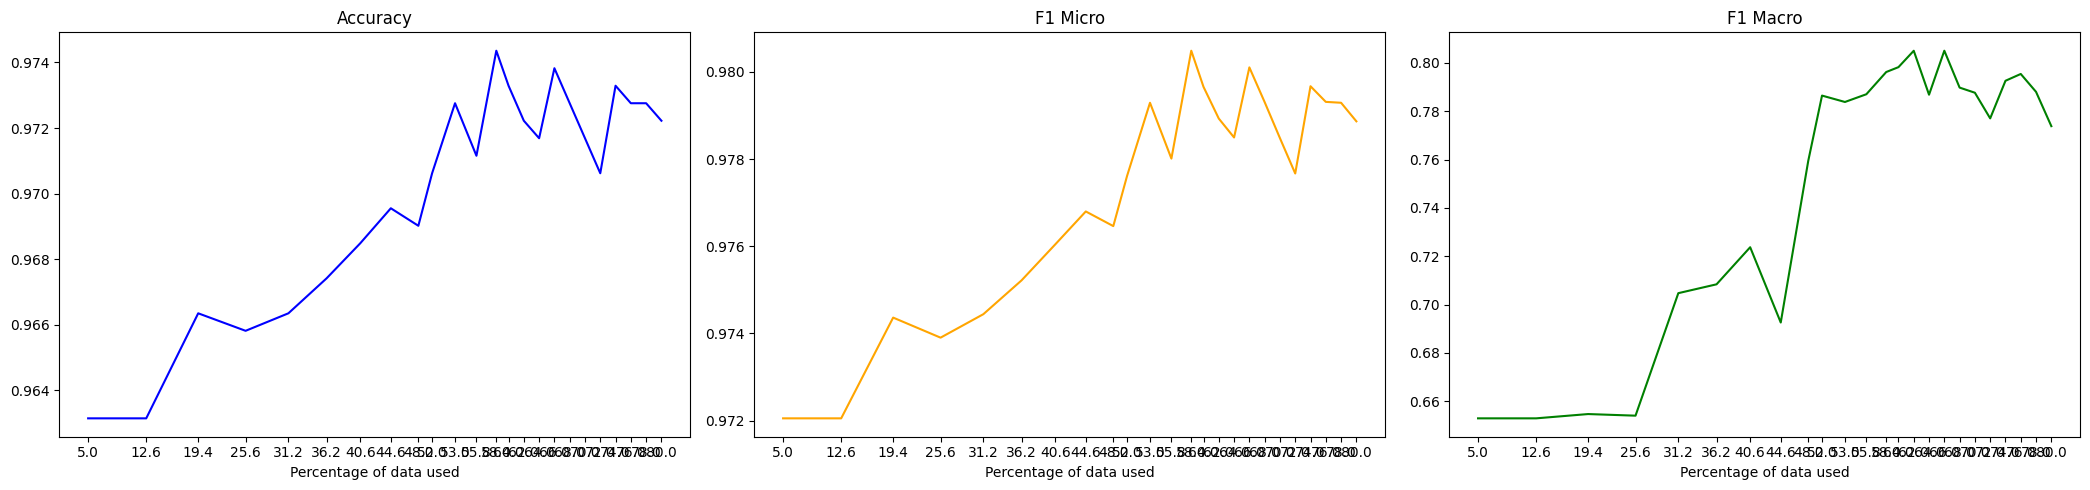

In [ ]:
active_learning(seeds[3], 3)

## RUN 5

TRIAL 5
Random seed: [94, 21, 5]
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5721, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3554, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2554, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1954, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2173, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1465, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2033, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.128, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5508, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3494, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2433, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1888, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2154, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1502, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.195, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1288, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5872, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3649, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2613, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2079, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.226, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1624, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2171, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1384, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4371, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2116, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1907, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1526, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1551, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1536, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1251, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1035, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4241, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2038, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1865, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1466, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1537, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1527, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1228, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.099, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.445, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2224, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2063, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1597, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1618, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.163, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1315, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1081, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3837, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.235, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1905, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1726, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.179, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 6/10, Train Loss: 0.1351, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.6528
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1503, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6533
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1373, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.6543
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0814, Accuracy: 0.9663, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3686, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.232, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1874, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1708, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1774, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1323, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1466, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.655
Epoch 8/10, Train Loss: 0.1417, Accuracy: 0.9599, F1 Micro: 0.9691, F1 Macro: 0.65
Epoch 9/10, Train Loss: 0.0758, Accuracy: 0.9455, F1 Micro: 0.9575, F1 Macro: 0.6404
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3952, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2467, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1965, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1757, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1826, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1377, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 7/10, Train Loss: 0.1619, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.6519
Epoch 8/10, Train Loss: 0.1609, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.652
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0929, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.6541
Highe

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3689, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.191, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.172, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2027, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1636, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1659, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6536
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.108, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.6561
Epoch 8/10, Train Loss: 0.1166, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6544
Epoch 9/10, Train Loss: 0.0969, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6544
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3582, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1876, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1718, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2057, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1631, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1619, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6552
Epoch 7/10, Train Loss: 0.1135, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.653
Epoch 8/10, Train Loss: 0.1126, Accuracy: 0.9583, F1 Micro: 0.9678, F1 Macro: 0.649
Epoch 9/10, Train Loss: 0.0841, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.6522
Epoch 10/10, Train Loss: 0.0763, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3749, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1979, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1774, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2085, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1658, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1631, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.6562
Epoch 7/10, Train Loss: 0.1217, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.6522


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

Epoch 8/10, Train Loss: 0.1192, Accuracy: 0.9599, F1 Micro: 0.9692, F1 Macro: 0.6502
Epoch 9/10, Train Loss: 0.0951, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.6512
Epoch 10/10, Train Loss: 0.0897, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.652
Model 3 - Iteration 128: Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.6562
              precision    recall  f1-score   support

        1-FR       1.00      1.00      1.00       104
        2-GI       0.00      0.00      0.00         4
        3-PI       1.00      1.00      1.00       104
        4-DM       0.89      1.00      0.94        89
     5-EDTRB       0.99      1.00      1.00       103
        6-RE       0.00      0.00      0.00         3

   micro avg       0.97      0.98      0.98       407
   macro avg       0.65      0.67      0.66       407
weighted avg       0.96      0.98      0.97       407
 samples avg       0.97      0.99      0.98       407

Training completed in 50.73548340797424 s
Averaged - Iteration 128: Ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3474, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1982, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1759, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1836, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1566, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1473, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.6561
Epoch 7/10, Train Loss: 0.1181, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6552
Epoch 8/10, Train Loss: 0.1005, Accuracy: 0.9599, F1 Micro: 0.9691, F1 Macro: 0.65
Epoch 9/10, Train Loss: 0.0689, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.651
Epoch 10/10, Train Loss: 0.062, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3424, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1976, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1732, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1851, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1563, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6536
Epoch 6/10, Train Loss: 0.141, Accuracy: 0.9615, F1 Micro: 0.9703, F1 Macro: 0.6509
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1165, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.6543
Epoch 8/10, Train Loss: 0.0953, Accuracy: 0.9583, F1 Micro: 0.9677, F1 Macro: 0.6488
Epoch 9/10, Train Loss: 0.0674, Accuracy: 0.9503, F1 Micro: 0.9613, F1 Macro: 0.6434
Higher F1 achieved, saving model
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3563, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2059, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1784, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1917, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1626, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1443, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.6541
Epoch 7/10, Train Loss: 0.1215, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6532
Epoch 8/10, Train Loss: 0.1021, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.652
Epoch 9/10, Train Loss: 0.0698, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.653
Epoch 10/10, Train Loss: 0.065, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.307, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1854, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1564, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1584, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.17, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.6561
Epoch 6/10, Train Loss: 0.1251, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.6528
Epoch 7/10, Train Loss: 0.1148, Accuracy: 0.9391, F1 Micro: 0.952, F1 Macro: 0.635
Epoch 8/10, Train Loss: 0.1004, Accuracy: 0.9551, F1 Micro: 0.9653, F1 Macro: 0.6471
Epoch 9/10, Train Loss: 0.0778, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6532
Epoch 10/10, Train Loss: 0.0578, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3014, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1855, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1557, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1592, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1723, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Epoch 6/10, Train Loss: 0.1171, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6532
Epoch 7/10, Train Loss: 0.1086, Accuracy: 0.9391, F1 Micro: 0.9521, F1 Macro: 0.6354
Epoch 8/10, Train Loss: 0.1022, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7623
Epoch 9/10, Train Loss: 0.0709, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6532
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0563, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3181, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1902, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1604, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.161, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1766, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.6562
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1267, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.6562
Epoch 7/10, Train Loss: 0.1113, Accuracy: 0.9599, F1 Micro: 0.969, F1 Macro: 0.6499
Epoch 8/10, Train Loss: 0.0908, Accuracy: 0.9583, F1 Micro: 0.9677, F1 Macro: 0.6486
Epoch 9/10, Train Loss: 0.0733, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7086
Epoch 10/10, Train Loss: 0.0576, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3024, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1563, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.17, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1547, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 5/10, Train Loss: 0.1664, Accuracy: 0.9599, F1 Micro: 0.969, F1 Macro: 0.6499
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.123, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1018, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6544
Epoch 8/10, Train Loss: 0.0733, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.6541
Epoch 9/10, Train Loss: 0.0617, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.6512
Epoch 10/10, Train Loss: 0.0422, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2975, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1576, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.17, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1571, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 5/10, Train Loss: 0.1626, Accuracy: 0.9359, F1 Micro: 0.9495, F1 Macro: 0.6329
Epoch 6/10, Train Loss: 0.1187, Accuracy: 0.9407, F1 Micro: 0.9533, F1 Macro: 0.6362
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0986, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.6561
Epoch 8/10, Train Loss: 0.0737, Accuracy: 0.9599, F1 Micro: 0.9692, F1 Macro: 0.6502
Epoch 9/10, Train Loss: 0.0628, Accuracy: 0.9567, F1 Micro: 0.9665, F1 Macro: 0.648
Epoch 10/10, Train Loss: 0.0421, Accuracy: 0.9631, F1 Micro: 0.9717, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3147, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1615, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1741, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1599, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1618, Accuracy: 0.9663, F1 Micro: 0.9741, F1 Macro: 0.6539
Epoch 6/10, Train Loss: 0.1248, Accuracy: 0.9631, F1 Micro: 0.9714, F1 Macro: 0.6516
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1095, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.657
Epoch 8/10, Train Loss: 0.0809, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.6551
Epoch 9/10, Train Loss: 0.0686, Accuracy: 0.9599, F1 Micro: 0.9692, F1 Macro: 0.6502
Epoch 10/10, Train Loss: 0.0477, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2714, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1833, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1591, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1522, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.6541
Epoch 5/10, Train Loss: 0.1483, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.135, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6544
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0991, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.6551
Epoch 8/10, Train Loss: 0.0868, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.6551
Epoch 9/10, Train Loss: 0.0579, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.6512
Epoch 10/10, Train Loss: 0.0427, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2684, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.182, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1605, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 4/10, Train Loss: 0.1567, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.6528
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1466, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1384, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6544
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0937, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.6551
Epoch 8/10, Train Loss: 0.0806, Accuracy: 0.9551, F1 Micro: 0.9653, F1 Macro: 0.6471
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0555, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7208
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2838, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1882, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1633, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.161, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1481, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1415, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.6561
Epoch 7/10, Train Loss: 0.1015, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.6551
Epoch 8/10, Train Loss: 0.0926, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7643
Epoch 9/10, Train Loss: 0.06, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.6551
Epoch 10/10, Train Loss: 0.0375, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2846, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1854, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.163, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Epoch 4/10, Train Loss: 0.1565, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6536
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1279, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6544
Epoch 6/10, Train Loss: 0.1066, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7198
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0697, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7801
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0464, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.798
Epoch 9/10, Train Loss: 0.0315, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7671
Epoch 10/10, Train Loss: 0.0305, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2781, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1859, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.167, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1606, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6544
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1254, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6552
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1041, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7969
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0641, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7801
Epoch 8/10, Train Loss: 0.0501, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.652
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0334, Accuracy: 0.9744, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2918, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1935, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1692, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1689, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1449, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1225, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.657
Epoch 7/10, Train Loss: 0.0857, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0602, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.7236
Epoch 9/10, Train Loss: 0.0453, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7502
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2857, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1765, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1557, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.15, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.6561
Epoch 5/10, Train Loss: 0.142, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.6522
Epoch 6/10, Train Loss: 0.1367, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6544
Epoch 7/10, Train Loss: 0.077, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0544, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.8024
Epoch 9/10, Train Loss: 0.0463, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7568
Epoch 10/10, Train Loss: 0.0258, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2801, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1749, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1574, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1492, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1433, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1332, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7522
Epoch 7/10, Train Loss: 0.0714, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.657
Epoch 8/10, Train Loss: 0.054, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.7236
Epoch 9/10, Train Loss: 0.047, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.7177
Epoch 10/10, Train Loss: 0.0275, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2932, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1803, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1559, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1494, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6532
Epoch 5/10, Train Loss: 0.137, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.653
Epoch 6/10, Train Loss: 0.1338, Accuracy: 0.9631, F1 Micro: 0.9722, F1 Macro: 0.7321
Epoch 7/10, Train Loss: 0.0775, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.652
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0577, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.7978
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0529, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.768
Epoch 10/10, Train Loss: 0.0304, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2611, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1802, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1641, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6536
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1459, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.6551
Epoch 5/10, Train Loss: 0.1144, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6532
Epoch 6/10, Train Loss: 0.0865, Accuracy: 0.9599, F1 Micro: 0.969, F1 Macro: 0.6499
Epoch 7/10, Train Loss: 0.0618, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7745
Epoch 8/10, Train Loss: 0.0455, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.6541
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0355, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7763
Epoch 10/10, Train Loss: 0.0269, Accuracy: 0.9631, F1 Micro: 0.9718, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2514, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1785, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1672, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1425, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.6551
Epoch 5/10, Train Loss: 0.1056, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.652
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0827, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7874
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0676, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7811
Epoch 8/10, Train Loss: 0.0441, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7623
Epoch 9/10, Train Loss: 0.0376, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.7929
Epoch 10/10, Train Loss: 0.0288, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.269, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1842, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1687, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1518, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6552
Epoch 5/10, Train Loss: 0.114, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.6543
Epoch 6/10, Train Loss: 0.0913, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.765
Epoch 7/10, Train Loss: 0.0716, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7577
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0517, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.798
Epoch 9/10, Train Loss: 0.0444, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.797
Epoch 10/10, Train Loss: 0.0306, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2694, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1929, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1674, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1297, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Epoch 5/10, Train Loss: 0.1258, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.6529
Epoch 6/10, Train Loss: 0.0875, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.653
Epoch 7/10, Train Loss: 0.053, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.7187
Epoch 8/10, Train Loss: 0.0496, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7636
Epoch 9/10, Train Loss: 0.0318, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7546
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0297, Accuracy: 0.9663, F1 Micro: 0.9745, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.267, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1919, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1718, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1326, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.126, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.653
Epoch 6/10, Train Loss: 0.0884, Accuracy: 0.9599, F1 Micro: 0.969, F1 Macro: 0.7155
Epoch 7/10, Train Loss: 0.0552, Accuracy: 0.9567, F1 Micro: 0.9665, F1 Macro: 0.7874
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0528, Accuracy: 0.9663, F1 Micro: 0.9741, F1 Macro: 0.7937
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0371, Accuracy: 0.9696, F1 Micro: 0.9766, F1 Macro: 0.7958
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2743, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1974, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1718, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1432, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.6562
Epoch 5/10, Train Loss: 0.1432, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.654
Epoch 6/10, Train Loss: 0.1089, Accuracy: 0.9615, F1 Micro: 0.9701, F1 Macro: 0.6505
Epoch 7/10, Train Loss: 0.0648, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7643
Epoch 8/10, Train Loss: 0.064, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7754
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0434, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7969
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0399, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2705, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1717, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1571, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1591, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.6541
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1212, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0866, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7383
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0579, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.798
Epoch 8/10, Train Loss: 0.0456, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.753
Epoch 9/10, Train Loss: 0.0357, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7623
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2692, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1732, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1588, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1609, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.6541
Epoch 5/10, Train Loss: 0.1175, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6532
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0817, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7633
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0585, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7561
Epoch 8/10, Train Loss: 0.0503, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7653
Epoch 9/10, Train Loss: 0.0405, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7449
Epoch 10/10, Train Loss: 0.0346, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2785, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1766, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.161, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1614, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1243, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.6561
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0886, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7502
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0581, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7893
Epoch 8/10, Train Loss: 0.0487, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.768
Epoch 9/10, Train Loss: 0.0442, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7671
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2575, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1752, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1792, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 4/10, Train Loss: 0.1641, Accuracy: 0.9567, F1 Micro: 0.9664, F1 Macro: 0.6476
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1218, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0923, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.798
Epoch 7/10, Train Loss: 0.0578, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7949
Epoch 8/10, Train Loss: 0.0347, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7654
Epoch 9/10, Train Loss: 0.0356, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7218
Epoch 10/10, Train Loss: 0.0233, Accuracy: 0.9712, F1 Micro: 0.978, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2562, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1752, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1791, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 4/10, Train Loss: 0.1547, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.6519
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1097, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7939
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0834, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7819
Epoch 7/10, Train Loss: 0.054, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.78
Epoch 8/10, Train Loss: 0.0396, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7662
Epoch 9/10, Train Loss: 0.0394, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7661
Epoch 10/10, Train Loss: 0.0229, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2691, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1791, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1804, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 4/10, Train Loss: 0.1663, Accuracy: 0.9615, F1 Micro: 0.9702, F1 Macro: 0.6507
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1258, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1053, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7226
Epoch 7/10, Train Loss: 0.0675, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7967
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0436, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7801
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0412, Accuracy: 0.9728, F1 Micro: 0.9791, F1 Macro: 0.7977
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2479, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1899, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1673, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1612, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6552
Epoch 5/10, Train Loss: 0.1033, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.6541
Epoch 6/10, Train Loss: 0.0794, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7577
Epoch 7/10, Train Loss: 0.0556, Accuracy: 0.9599, F1 Micro: 0.9697, F1 Macro: 0.7421
Epoch 8/10, Train Loss: 0.0429, Accuracy: 0.9663, F1 Micro: 0.9746, F1 Macro: 0.7578
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0249, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7763
Epoch 10/10, Train Loss: 0.0235, Accuracy: 0.9663, F1 Micro: 0.9745, F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2423, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1891, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1696, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.164, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.6562
Epoch 5/10, Train Loss: 0.11, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6532
Epoch 6/10, Train Loss: 0.0869, Accuracy: 0.9631, F1 Micro: 0.9722, F1 Macro: 0.744
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0596, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.8218
Epoch 8/10, Train Loss: 0.0488, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.798
Epoch 9/10, Train Loss: 0.0304, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.798
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0244, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2558, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.192, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1703, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1661, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6552
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1154, Accuracy: 0.9696, F1 Micro: 0.9766, F1 Macro: 0.6558
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.091, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7892
Epoch 7/10, Train Loss: 0.0625, Accuracy: 0.9679, F1 Micro: 0.9753, F1 Macro: 0.7997
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0495, Accuracy: 0.9776, F1 Micro: 0.9829, F1 Macro: 0.8236
Epoch 9/10, Train Loss: 0.0306, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7586
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2486, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1756, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1766, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1468, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.6541
Epoch 5/10, Train Loss: 0.1103, Accuracy: 0.9583, F1 Micro: 0.9681, F1 Macro: 0.749
Epoch 6/10, Train Loss: 0.068, Accuracy: 0.9647, F1 Micro: 0.9733, F1 Macro: 0.7567
Epoch 7/10, Train Loss: 0.0603, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7643
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0331, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7811
Epoch 9/10, Train Loss: 0.0329, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.798
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0262, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2426, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1754, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1756, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1514, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.6561
Epoch 5/10, Train Loss: 0.1158, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.7187
Epoch 6/10, Train Loss: 0.0734, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.778
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0593, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.798
Epoch 8/10, Train Loss: 0.0331, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7884
Epoch 9/10, Train Loss: 0.0345, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.8207
Epoch 10/10, Train Loss: 0.0256, Accuracy: 0.9712, F1 Micro: 0.978, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2564, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1785, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1774, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1518, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.6562
Epoch 5/10, Train Loss: 0.1273, Accuracy: 0.9583, F1 Micro: 0.9678, F1 Macro: 0.649
Epoch 6/10, Train Loss: 0.0866, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.753
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0705, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7811
Epoch 8/10, Train Loss: 0.0386, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.747
Epoch 9/10, Train Loss: 0.0421, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7791
Epoch 10/10, Train Loss: 0.0284, Accuracy: 0.9712, F1 Micro: 0.978, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2407, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1685, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1512, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.6561
Epoch 4/10, Train Loss: 0.1275, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1082, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7811
Epoch 6/10, Train Loss: 0.067, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7494
Epoch 7/10, Train Loss: 0.0709, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.7803
Epoch 8/10, Train Loss: 0.0355, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7541
Epoch 9/10, Train Loss: 0.0287, Accuracy: 0.9631, F1 Micro: 0.9722, F1 Macro: 0.7495
Epoch 10/10, Train Loss: 0.025, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7577
Model 1 - Iteration

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2342, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1677, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1543, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Epoch 4/10, Train Loss: 0.1305, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.653
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1062, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7673
Epoch 6/10, Train Loss: 0.0655, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.7671
Epoch 7/10, Train Loss: 0.0673, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.798
Epoch 8/10, Train Loss: 0.0341, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.781
Epoch 9/10, Train Loss: 0.0258, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7763
Epoch 10/10, Train Loss: 0.0201, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.781
Model 2 - Iteration 33

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2469, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1703, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1554, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Epoch 4/10, Train Loss: 0.1313, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.6549
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1179, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.6562
Epoch 6/10, Train Loss: 0.0748, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.655
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0754, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.798
Epoch 8/10, Train Loss: 0.0409, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7959
Epoch 9/10, Train Loss: 0.0315, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7561
Epoch 10/10, Train Loss: 0.0246, Accuracy: 0.9679, F1 Micro: 0.9757, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2439, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1696, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1529, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1404, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7811
Epoch 5/10, Train Loss: 0.0993, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.763
Epoch 6/10, Train Loss: 0.0763, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7875
Epoch 7/10, Train Loss: 0.0559, Accuracy: 0.9631, F1 Micro: 0.9723, F1 Macro: 0.7441
Epoch 8/10, Train Loss: 0.0396, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7778
Epoch 9/10, Train Loss: 0.0289, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7875
Epoch 10/10, Train Loss: 0.0288, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7438
Model 1 - Iteratio

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2389, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1687, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1555, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1497, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.7673
Epoch 5/10, Train Loss: 0.1097, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7951
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0876, Accuracy: 0.9744, F1 Micro: 0.9806, F1 Macro: 0.7903
Epoch 7/10, Train Loss: 0.0614, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.797
Epoch 8/10, Train Loss: 0.0449, Accuracy: 0.9583, F1 Micro: 0.9679, F1 Macro: 0.7046
Epoch 9/10, Train Loss: 0.0273, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7672
Epoch 10/10, Train Loss: 0.0317, Accuracy: 0.9663, F1 Micro: 0.9742, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2505, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1735, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1549, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1535, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7218
Epoch 5/10, Train Loss: 0.1146, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7651
Epoch 6/10, Train Loss: 0.0879, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7503
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0664, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.78
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0456, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.767
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0284, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.781
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2487, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1604, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1399, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Epoch 4/10, Train Loss: 0.1488, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6544
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0975, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.798
Epoch 6/10, Train Loss: 0.0784, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7494
Epoch 7/10, Train Loss: 0.0507, Accuracy: 0.9647, F1 Micro: 0.9733, F1 Macro: 0.7535
Epoch 8/10, Train Loss: 0.0407, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7949
Epoch 9/10, Train Loss: 0.0349, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7763
Epoch 10/10, Train Loss: 0.0243, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7875
Model 1 - Iteratio

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2447, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1617, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.141, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1486, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0978, Accuracy: 0.9744, F1 Micro: 0.9804, F1 Macro: 0.7988
Epoch 6/10, Train Loss: 0.0784, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.762
Epoch 7/10, Train Loss: 0.0486, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.768
Epoch 8/10, Train Loss: 0.0425, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7772
Epoch 9/10, Train Loss: 0.036, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.7672
Epoch 10/10, Train Loss: 0.0208, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2543, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1644, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1414, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1461, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.6561
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0992, Accuracy: 0.9744, F1 Micro: 0.9804, F1 Macro: 0.7988
Epoch 6/10, Train Loss: 0.0806, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7584
Epoch 7/10, Train Loss: 0.0547, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7459
Epoch 8/10, Train Loss: 0.0499, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7969
Epoch 9/10, Train Loss: 0.042, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.756
Epoch 10/10, Train Loss: 0.0241, Accuracy: 0.9679, F1 Micro: 0.9757, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2425, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1657, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1582, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1279, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.6551
Epoch 5/10, Train Loss: 0.1076, Accuracy: 0.9583, F1 Micro: 0.9677, F1 Macro: 0.7578
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0693, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7672
Epoch 7/10, Train Loss: 0.0516, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7643
Epoch 8/10, Train Loss: 0.0388, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7883
Epoch 9/10, Train Loss: 0.0277, Accuracy: 0.9663, F1 Micro: 0.9746, F1 Macro: 0.7578
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0189, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2418, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1671, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1606, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1354, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1061, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7951
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0668, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.797
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0506, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.7681
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0438, Accuracy: 0.9744, F1 Micro: 0.9806, F1 Macro: 0.8043
Epoch 9/10, Train Loss: 0.03, Accuracy: 0.9712, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2518, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1691, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1605, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1343, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.6561
Epoch 5/10, Train Loss: 0.0985, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7769
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0747, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7967
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0515, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.781
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0451, Accuracy: 0.976, F1 Micro: 0.9816, F1 Macro: 0.7997
Epoch 9/10, Train Loss: 0.033, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.7773
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2326, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1531, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1705, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Epoch 4/10, Train Loss: 0.1387, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.6551
Epoch 5/10, Train Loss: 0.1171, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.653
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0727, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7981
Epoch 7/10, Train Loss: 0.0459, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7844
Epoch 8/10, Train Loss: 0.0346, Accuracy: 0.9663, F1 Micro: 0.9746, F1 Macro: 0.7578
Epoch 9/10, Train Loss: 0.0298, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7533
Epoch 10/10, Train Loss: 0.0236, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7541
Model 1 - Iteration

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2312, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1538, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1702, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6544
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1351, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7228
Epoch 5/10, Train Loss: 0.1085, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0679, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7989
Epoch 7/10, Train Loss: 0.0435, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7969
Epoch 8/10, Train Loss: 0.0349, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.798
Epoch 9/10, Train Loss: 0.0345, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7978
Epoch 10/10, Train Loss: 0.0276, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2388, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1581, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1748, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.6562
Epoch 4/10, Train Loss: 0.1397, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.6522
Epoch 5/10, Train Loss: 0.1217, Accuracy: 0.9599, F1 Micro: 0.9689, F1 Macro: 0.6497
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.076, Accuracy: 0.9744, F1 Micro: 0.9804, F1 Macro: 0.7818
Epoch 7/10, Train Loss: 0.0468, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7882
Epoch 8/10, Train Loss: 0.0381, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.778
Epoch 9/10, Train Loss: 0.0322, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.764
Epoch 10/10, Train Loss: 0.0329, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7751
Model 3 - Iteration 3

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2551, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1705, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1538, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1268, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.7671
Epoch 5/10, Train Loss: 0.0936, Accuracy: 0.9663, F1 Micro: 0.9746, F1 Macro: 0.7655
Epoch 6/10, Train Loss: 0.0561, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7481
Epoch 7/10, Train Loss: 0.0503, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7764
Epoch 8/10, Train Loss: 0.0317, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7576
Epoch 9/10, Train Loss: 0.0309, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7747
Epoch 10/10, Train Loss: 0.022, Accuracy: 0.9631, F1 Micro: 0.9722, F1 Macro: 0.7495
Model 1 - Iteration

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2522, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1722, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1601, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1402, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1064, Accuracy: 0.976, F1 Micro: 0.9817, F1 Macro: 0.7999
Epoch 6/10, Train Loss: 0.0661, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7871
Epoch 7/10, Train Loss: 0.0564, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7661
Epoch 8/10, Train Loss: 0.0361, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7566
Epoch 9/10, Train Loss: 0.0323, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7672
Epoch 10/10, Train Loss: 0.0232, Accuracy: 0.9696, F1 Micro: 0.9769, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2615, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1746, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1616, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1416, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1106, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7894
Epoch 6/10, Train Loss: 0.0655, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.7525
Epoch 7/10, Train Loss: 0.0563, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.7411
Epoch 8/10, Train Loss: 0.0381, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7539
Epoch 9/10, Train Loss: 0.0382, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.7808
Epoch 10/10, Train Loss: 0.028, Accuracy: 0.9696, F1 Micro: 0.9769, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2104, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1706, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.145, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1452, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6532
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1082, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7801
Epoch 6/10, Train Loss: 0.0703, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7643
Epoch 7/10, Train Loss: 0.0486, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7418
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0365, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7884
Epoch 9/10, Train Loss: 0.0331, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7875
Epoch 10/10, Train Loss: 0.0196, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.205, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1701, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.145, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 4/10, Train Loss: 0.1425, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.6522
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1029, Accuracy: 0.976, F1 Micro: 0.9817, F1 Macro: 0.7999
Epoch 6/10, Train Loss: 0.0651, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.777
Epoch 7/10, Train Loss: 0.047, Accuracy: 0.9744, F1 Micro: 0.9804, F1 Macro: 0.7988
Epoch 8/10, Train Loss: 0.0375, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7989
Epoch 9/10, Train Loss: 0.0356, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7864
Epoch 10/10, Train Loss: 0.0207, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7781
Model 2 - Iteration 39

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2177, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1723, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1469, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1431, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6532
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1135, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.6569
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0784, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.803
Epoch 7/10, Train Loss: 0.0531, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7883
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0388, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.8041
Epoch 9/10, Train Loss: 0.0381, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.803
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2297, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1664, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1367, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1207, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.6562
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0885, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7973
Epoch 6/10, Train Loss: 0.0705, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7551
Epoch 7/10, Train Loss: 0.0494, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7429
Epoch 8/10, Train Loss: 0.0329, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7087
Epoch 9/10, Train Loss: 0.025, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7653
Epoch 10/10, Train Loss: 0.0228, Accuracy: 0.9679, F1 Micro: 0.9757, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2273, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1667, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1388, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1229, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.6561
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0903, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7227
Epoch 6/10, Train Loss: 0.067, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.796
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0622, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7989
Epoch 8/10, Train Loss: 0.0363, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7951
Epoch 9/10, Train Loss: 0.0267, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.798
Epoch 10/10, Train Loss: 0.0253, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2383, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1688, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1378, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.6562
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1246, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.6562
Epoch 5/10, Train Loss: 0.0933, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.6551
Epoch 6/10, Train Loss: 0.071, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7751
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0584, Accuracy: 0.9744, F1 Micro: 0.9804, F1 Macro: 0.79
Epoch 8/10, Train Loss: 0.0371, Accuracy: 0.9696, F1 Micro: 0.9766, F1 Macro: 0.765
Epoch 9/10, Train Loss: 0.0369, Accuracy: 0.9567, F1 Micro: 0.9674, F1 Macro: 0.7382
Epoch 10/10, Train Loss: 0.0307, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Ma

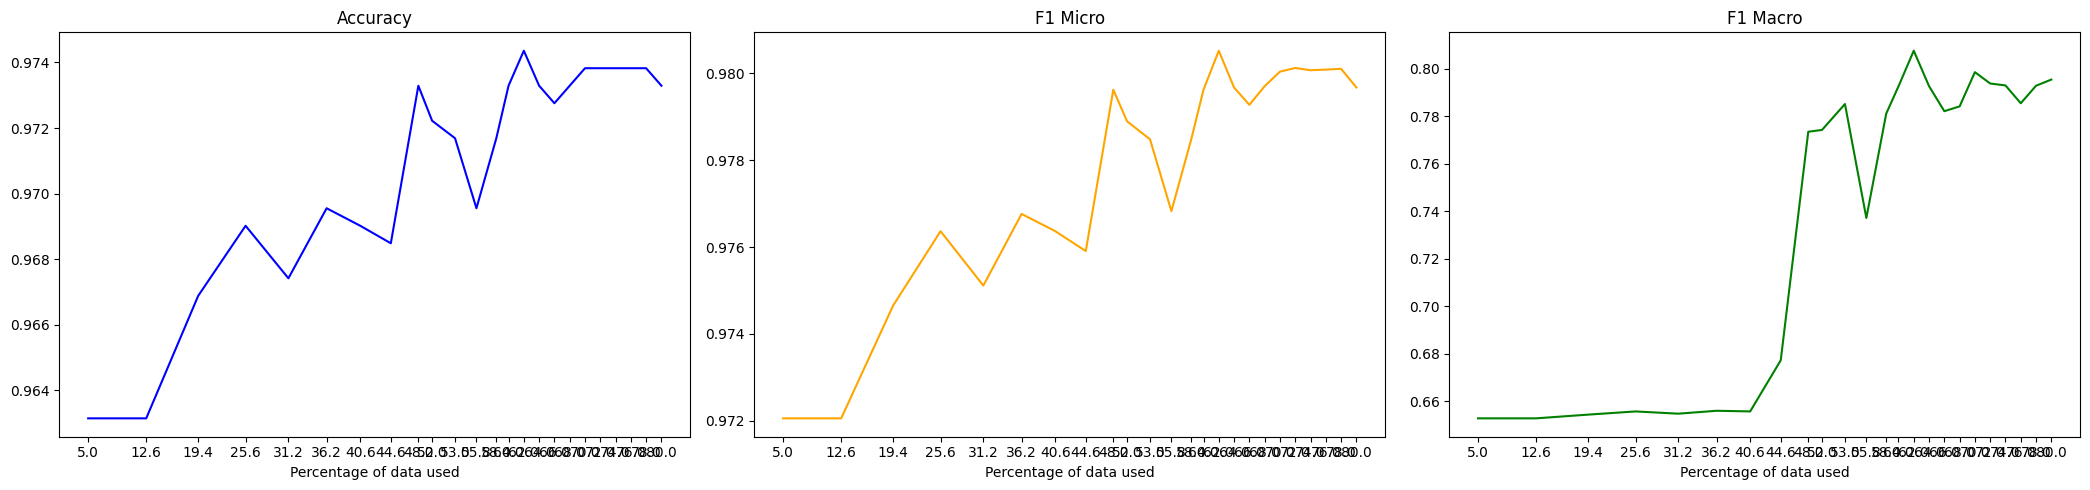

In [ ]:
active_learning(seeds[4], 4)